In [13]:
import os

# create output directory
path = "graphs"
if not os.path.isdir(path):
    os.makedirs(path)

In [14]:
# Section 1: Building the Road Network Graph from Real Louisville Data

import geopandas as gpd
import networkx as nx
import matplotlib.pyplot as plt
from shapely.geometry import Point, LineString
from shapely.ops import unary_union
import pandas as pd
import numpy as np
from collections import defaultdict
import warnings
warnings.filterwarnings('ignore')

# --- Step 1: Load the Real Street Data ---
street_data_path = "Jefferson_County_KY_Street_Centerlines.shp"
print(f"Loading street data from {street_data_path}...")
streets_gdf = gpd.read_file(street_data_path)

print(f"Original CRS: {streets_gdf.crs}")
print(f"Number of road segments: {len(streets_gdf)}")
print(f"Data bounds: {streets_gdf.total_bounds}")

# IMPORTANT: Convert to a metric CRS for accurate distance calculations in meters
# The Shapefile is in State Plane Kentucky North (US survey feet), convert to UTM zone 16N (meters)
streets_gdf = streets_gdf.to_crs(epsg=32616)  # UTM zone 16N for Kentucky
print(f"Converted CRS: {streets_gdf.crs}")

# Filter out invalid geometries and ensure we only have LineStrings
streets_gdf = streets_gdf[streets_gdf.geometry.type == 'LineString'].copy()
print(f"Valid LineString segments: {len(streets_gdf)}")

print("\nStreet data loaded. Sample of the dataframe:")
print(streets_gdf.head())

# --- Step 2: Extract All Unique Points (Intersections) ---
# Every road segment (LineString) has a start and end point. These are our potential nodes.
points = []
for line in streets_gdf.geometry:
    if line.is_valid and len(line.coords) >= 2:
        start_point = tuple(line.coords[0])
        end_point = tuple(line.coords[-1])
        points.append(start_point)
        points.append(end_point)

# Use a set to get only the unique points (intersections)
unique_points = list(set(points))
print(f"\nFound {len(unique_points)} unique intersection points.")

# --- Step 3: Create the Graph and Add Nodes ---
G = nx.Graph()

# Create a mapping from coordinate tuple to a simple integer ID for our graph
point_to_id = {point: i for i, point in enumerate(unique_points)}
id_to_point = {i: point for point, i in point_to_id.items()}

for point, node_id in point_to_id.items():
    G.add_node(node_id, pos=point)

# --- Step 4: Add Edges ---
# Iterate through the original road lines and connect their start/end nodes
edges_added = 0
for line in streets_gdf.geometry:
    if line.is_valid and len(line.coords) >= 2:
        start_point = tuple(line.coords[0])
        end_point = tuple(line.coords[-1])
        
        u = point_to_id[start_point]
        v = point_to_id[end_point]
        
        # Skip self-loops
        if u == v:
            continue
        
        # The displacement of the road segment is our edge weight (in meters)
        displacement = Point(start_point).distance(Point(end_point))
        
        # Add the edge to the graph with its length as a weight
        # If edge already exists, keep the shorter one
        if G.has_edge(u, v):
            if displacement < G[u][v]['weight']:
                G[u][v]['weight'] = displacement
        else:
            G.add_edge(u, v, weight=displacement)
            edges_added += 1

print(f"Successfully created a graph with {len(G.nodes)} nodes and {len(G.edges)} edges.")

# Store graph and mappings globally for use in other cells
%store G
%store point_to_id
%store id_to_point
%store streets_gdf

Loading street data from Jefferson_County_KY_Street_Centerlines.shp...
Original CRS: EPSG:2246
Number of road segments: 35035
Data bounds: [1152765.375    186710.39125 1326040.77625  322250.0625 ]
Converted CRS: EPSG:32616
Valid LineString segments: 35035

Street data loaded. Sample of the dataframe:
   OBJECTID  RWCOMPKEY  RWCOMPKEYP LOW_ADDRES  FROM_ADDRE  TO_ADDRESS  LFROM  \
0         1      24074           0       6300        6300        6399   6301   
1         2      20311           0       1600        1600        1619   1601   
2         3      21109           0       1700        1700        1705   1701   
3         4      20926           0        505         505         519    505   
4         5      19036           0        730         730         799    731   

    LTO  RFROM   RTO  ...  ALIAS3_STR ALIAS3_TYP ALIAS3_SIF ALIAS4_DIR  \
0  6399   6300  6398  ...        None       None          0       None   
1  1619   1600  1618  ...        None       None          0       Non

In [15]:
# Section 2: Helper Functions and Accident Hotspot Data

def find_nearest_node_id(target_point, id_to_point_map):
    """
    Finds the nearest node ID to a given target point.
    id_to_point_map maps node_id -> (x, y) coordinate.
    """
    min_dist = float('inf')
    nearest_id = None
    target_geom = Point(target_point) if not isinstance(target_point, Point) else target_point
    for node_id, coord in id_to_point_map.items():
        coord_geom = Point(coord)
        dist = target_geom.distance(coord_geom)
        if dist < min_dist:
            min_dist = dist
            nearest_id = node_id
    return nearest_id

# --- Create Accident Hotspot Data ON STREET SEGMENTS ---
# Hotspots are placed directly on road segments randomly
# Some hotspots are created in clusters (within 200m) to simulate accident-prone areas

np.random.seed(42)  # This is for reproducibility

# Create many more hotspots (100-200) placed along actual street segments
num_hotspots = 150 
hotspots = []
cluster_radius = 200 

print(f"Creating {num_hotspots} accident hotspots on street segments...")
print(f"Some hotspots will be clustered within {cluster_radius}m of each other...")

num_clusters = 8 
cluster_centers = []

sampled_streets_for_clusters = streets_gdf.sample(n=num_clusters, random_state=42)
for idx, street_row in sampled_streets_for_clusters.iterrows():
    line = street_row.geometry
    if line.is_valid and len(line.coords) >= 2:
        line_length = line.length
        if line_length > 0:
            distance_along = np.random.uniform(0.2 * line_length, 0.8 * line_length)
            cluster_center = line.interpolate(distance_along)
            cluster_centers.append((cluster_center.x, cluster_center.y))

hotspots_per_cluster = 4
for center_x, center_y in cluster_centers:
    center_point = Point(center_x, center_y)
    
    nearby_streets = streets_gdf[streets_gdf.geometry.distance(center_point) <= cluster_radius * 2]
    
    if len(nearby_streets) > 0:
        for _ in range(hotspots_per_cluster):
            if len(hotspots) >= num_hotspots:
                break
            
            street_row = nearby_streets.sample(n=1).iloc[0]
            line = street_row.geometry
            
            if line.is_valid and len(line.coords) >= 2:
                line_length = line.length
                if line_length > 0:
                    distance_along = np.random.uniform(0.1 * line_length, 0.9 * line_length)
                    hotspot_point = line.interpolate(distance_along)
                    
                    # Check if within cluster radius of center
                    if hotspot_point.distance(center_point) <= cluster_radius:
                        weight = np.random.uniform(0.5, 1.0)  # Higher weight for clustered hotspots
                        hotspots.append((hotspot_point.x, hotspot_point.y, weight))

remaining_hotspots = num_hotspots - len(hotspots)
if remaining_hotspots > 0:
    print(f"Adding {remaining_hotspots} additional randomly distributed hotspots...")
    sampled_streets = streets_gdf.sample(n=min(remaining_hotspots * 2, len(streets_gdf)), random_state=42)
    
    for idx, street_row in sampled_streets.iterrows():
        if len(hotspots) >= num_hotspots:
            break
        
        line = street_row.geometry
        if line.is_valid and len(line.coords) >= 2:
            line_length = line.length
            if line_length > 0:
                distance_along = np.random.uniform(0.1 * line_length, 0.9 * line_length)
                hotspot_point = line.interpolate(distance_along)
                weight = np.random.uniform(0.2, 0.9)
                hotspots.append((hotspot_point.x, hotspot_point.y, weight))

# If still need more, add to longer streets
if len(hotspots) < num_hotspots:
    streets_gdf['length'] = streets_gdf.geometry.length
    long_streets = streets_gdf.nlargest(50, 'length')
    
    for idx, street_row in long_streets.iterrows():
        if len(hotspots) >= num_hotspots:
            break
        
        line = street_row.geometry
        if line.is_valid and len(line.coords) >= 2:
            line_length = line.length
            if line_length > 100:
                num_on_street = min(2, num_hotspots - len(hotspots))
                for _ in range(num_on_street):
                    distance_along = np.random.uniform(0.1 * line_length, 0.9 * line_length)
                    hotspot_point = line.interpolate(distance_along)
                    weight = np.random.uniform(0.3, 1.0)
                    hotspots.append((hotspot_point.x, hotspot_point.y, weight))

# Convert to GeoDataFrame for easier handling
hotspot_points = [Point(x, y) for x, y, _ in hotspots]
hotspot_weights = [w for _, _, w in hotspots]

hotspots_gdf = gpd.GeoDataFrame({
    'risk_weight': hotspot_weights,
    'geometry': hotspot_points
}, crs=streets_gdf.crs)

print(f"Created {len(hotspots)} accident hotspots ON street segments")
print(f"Risk weight range: {min(hotspot_weights):.2f} - {max(hotspot_weights):.2f}")

Creating 150 accident hotspots on street segments...
Some hotspots will be clustered within 200m of each other...
Adding 144 additional randomly distributed hotspots...
Created 150 accident hotspots ON street segments
Risk weight range: 0.20 - 0.94


In [16]:
# Section 3: Coverage Calculation Functions / Helper Functions

def get_covered_hotspots(node, id_to_point, hotspots_gdf, coverage_radius_meters):
    covered_hotspots = set()
    placement = Point(id_to_point[node])
    for i, hotspot_node in enumerate(hotspots_gdf.geometry):
        if placement.distance(hotspot_node) <= coverage_radius_meters:
            covered_hotspots.add(i)
    return covered_hotspots


def create_covered_hotspot_cache(G, id_to_point, hotspots_gdf, coverage_radius_meters):
    node_coverage_cache = {}

    for node in G:
        node_coverage_cache[node] = get_covered_hotspots(node, id_to_point, hotspots_gdf, coverage_radius_meters)

    return node_coverage_cache

def calculate_coverage(camera_nodes, id_to_point, hotspots_gdf, coverage_radius_meters):
    """
    Calculate the total weighted coverage of hotspots by cameras.
    
    Parameters:
    - camera_nodes: list of node IDs where cameras are placed
    - node_coverage_cache: list of hotspots covered by each node ID location
    
    Returns:
    - total_coverage: sum of weights of covered hotspots
    - covered_hotspots: list of hotspot indices that are covered
    """
    covered_hotspots = set()
    
    # For each camera, find all hotspots within coverage radius
    for camera_node in camera_nodes:
        camera_covered = get_covered_hotspots(camera_node, id_to_point, hotspots_gdf, coverage_radius_meters)
        covered_hotspots.update(camera_covered)
    
    hotspot_weights = hotspots_gdf.risk_weight
    total_coverage = sum(hotspot_weights[i] for i in covered_hotspots)
    
    return total_coverage, list(covered_hotspots)

def calculate_map_coverage(camera_nodes, id_to_point, streets_gdf, coverage_radius_meters):
    """
    Calculate the total geographic area covered by cameras.
    
    Parameters:
    - camera_nodes: list of node IDs where cameras are placed
    - id_to_point: mapping from node ID to coordinates
    - streets_gdf: GeoDataFrame of streets (for bounds)
    - coverage_radius_meters: coverage radius in meters
    
    Returns:
    - total_area_covered: total area covered by all cameras (in square meters)
    - coverage_percentage: percentage of map area covered
    - coverage_union: union of all coverage circles as a GeoSeries
    """
    # map bounds
    bounds = streets_gdf.total_bounds
    map_area = (bounds[2] - bounds[0]) * (bounds[3] - bounds[1]) 
    
    coverage_circles = []
    for node_id in camera_nodes:
        camera_point = Point(id_to_point[node_id])
        circle = camera_point.buffer(coverage_radius_meters)
        coverage_circles.append(circle)
    
    if len(coverage_circles) > 0:
        coverage_union_geom = unary_union(coverage_circles)
        total_area_covered = coverage_union_geom.area
        coverage_percentage = (total_area_covered / map_area) * 100
        coverage_union = gpd.GeoSeries([coverage_union_geom], crs=streets_gdf.crs)
    else:
        total_area_covered = 0
        coverage_percentage = 0
        coverage_union = gpd.GeoSeries([], crs=streets_gdf.crs)
    
    return total_area_covered, coverage_percentage, coverage_union

def print_coverage_stats(camera_nodes, hotspots_gdf,
                         coverage_radius_meters, id_to_point, streets_gdf, algorithm_name=""):
    """
    Print comprehensive coverage statistics.
    """
    hotspot_weights = hotspots_gdf.risk_weight

    # Calculate hotspot coverage
    hotspot_coverage, covered_hotspot_indices = calculate_coverage(
        camera_nodes, id_to_point, hotspots_gdf, coverage_radius_meters
    )
    total_hotspot_weight = sum(hotspot_weights)
    hotspot_coverage_pct = (hotspot_coverage / total_hotspot_weight) * 100 if total_hotspot_weight > 0 else 0
    
    # Calculate map coverage
    map_area_covered, map_coverage_pct, coverage_union = calculate_map_coverage(
        camera_nodes, id_to_point, streets_gdf, coverage_radius_meters
    )
    
    print("=" * 60)
    if algorithm_name:
        print(f"{algorithm_name} - Coverage Statistics")
    else:
        print("Coverage Statistics")
    print("=" * 60)
    print(f"Hotspot Coverage:")
    print(f"  - Covered Hotspots: {len(covered_hotspot_indices)} / {len(hotspot_weights)}")
    print(f"  - Weighted Coverage: {hotspot_coverage:.2f} / {total_hotspot_weight:.2f}")
    print(f"  - Coverage Percentage: {hotspot_coverage_pct:.1f}%")
    print(f"\nMap Coverage:")
    print(f"  - Area Covered: {map_area_covered / 1000000:.2f} km²")
    print(f"  - Map Coverage Percentage: {map_coverage_pct:.1f}%")
    print("=" * 60)
    
    return {
        'hotspot_coverage': hotspot_coverage,
        'hotspot_coverage_pct': hotspot_coverage_pct,
        'covered_hotspots': len(covered_hotspot_indices),
        'total_hotspots': len(hotspot_weights),
        'map_area_covered': map_area_covered,
        'map_coverage_pct': map_coverage_pct
    }



In [17]:
NUM_CAMERAS = 10  # Number of cameras to place
COVERAGE_RADIUS = 2000  # Coverage radius in meters

GREEDY ALGORITHM
Starting greedy selection...

Creating visualization of hotspots and road network...
Saved: hotspots_map.png


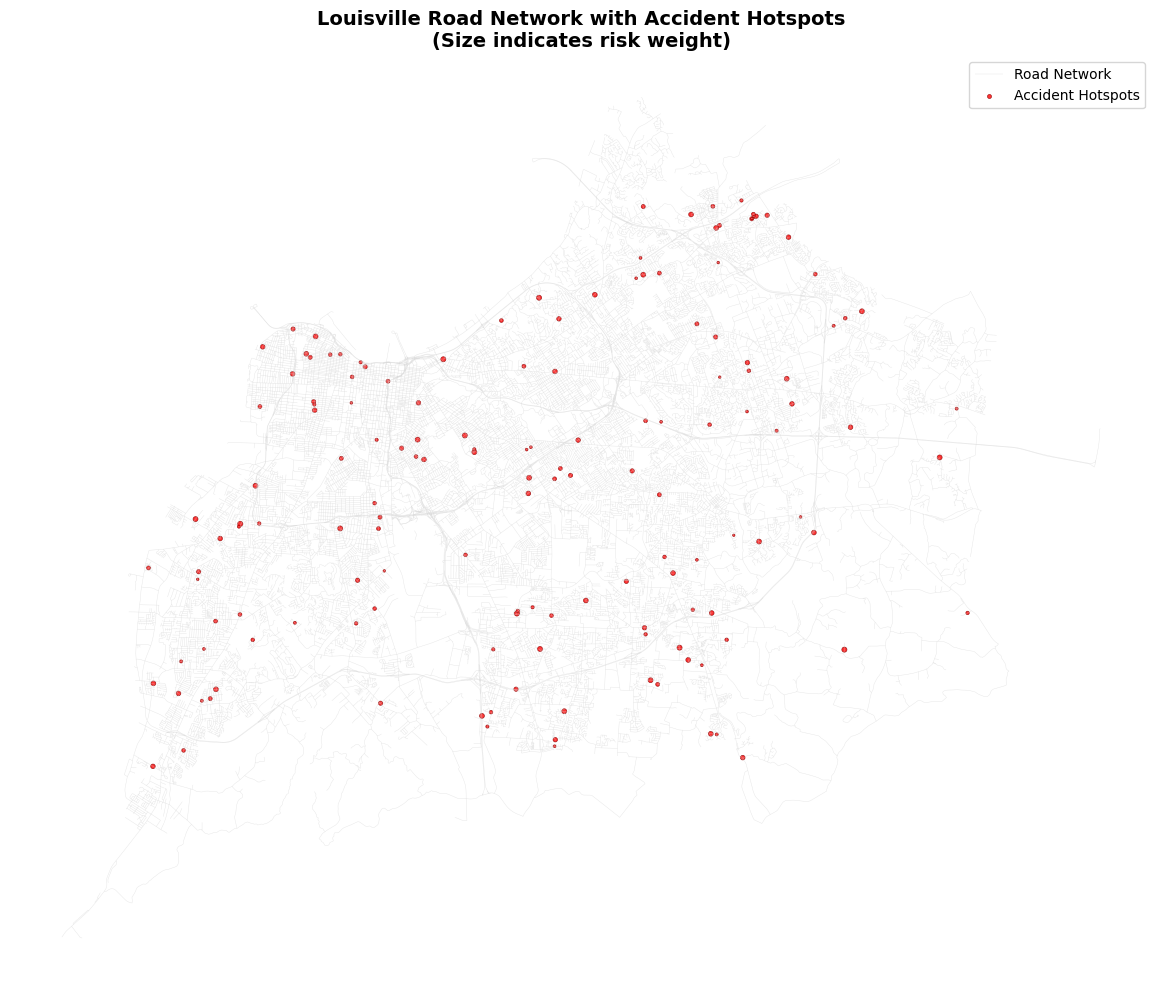

Step 1: Placed camera at node 26122, additional coverage: 7.27, total coverage: 7.27


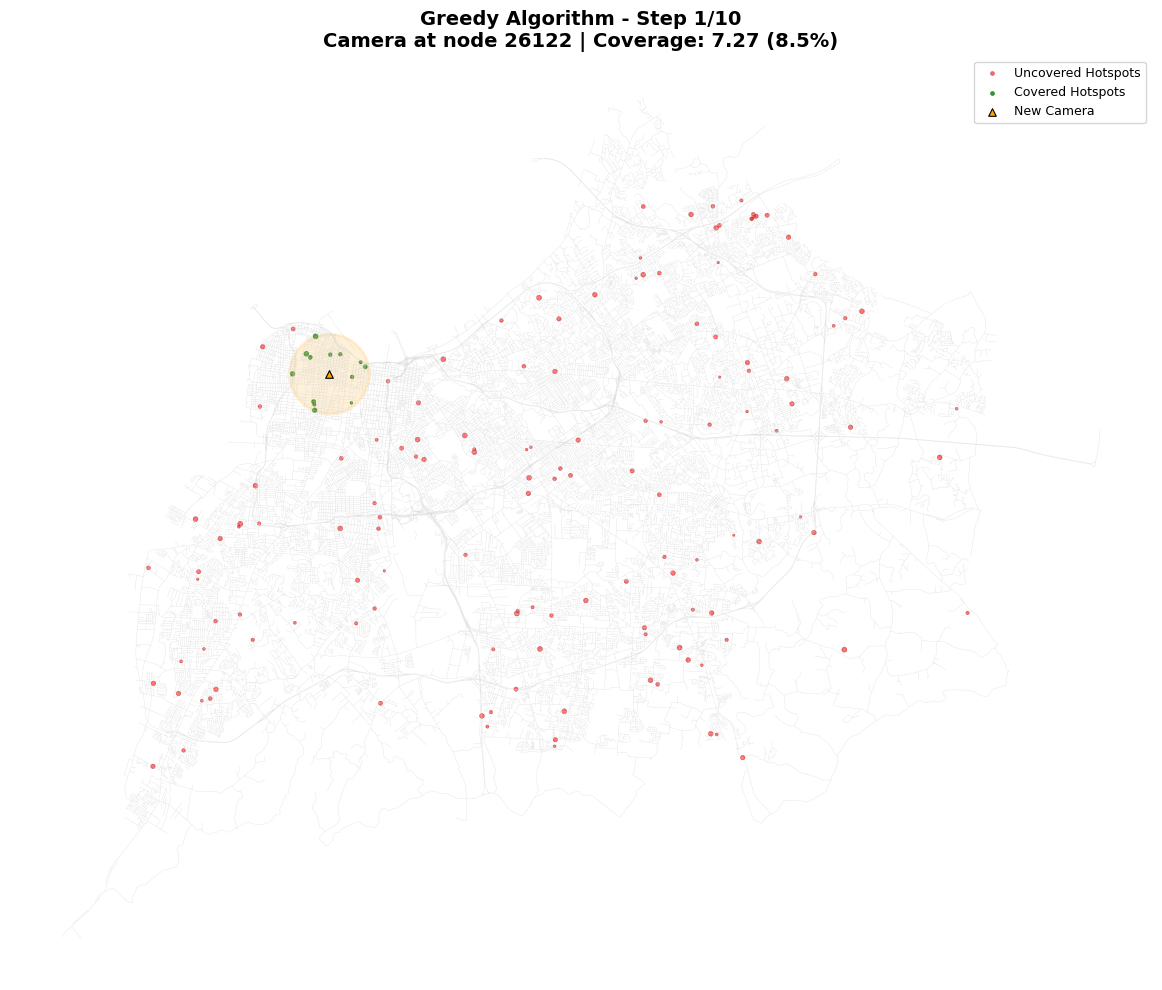

Step 2: Placed camera at node 16639, additional coverage: 6.06, total coverage: 13.33


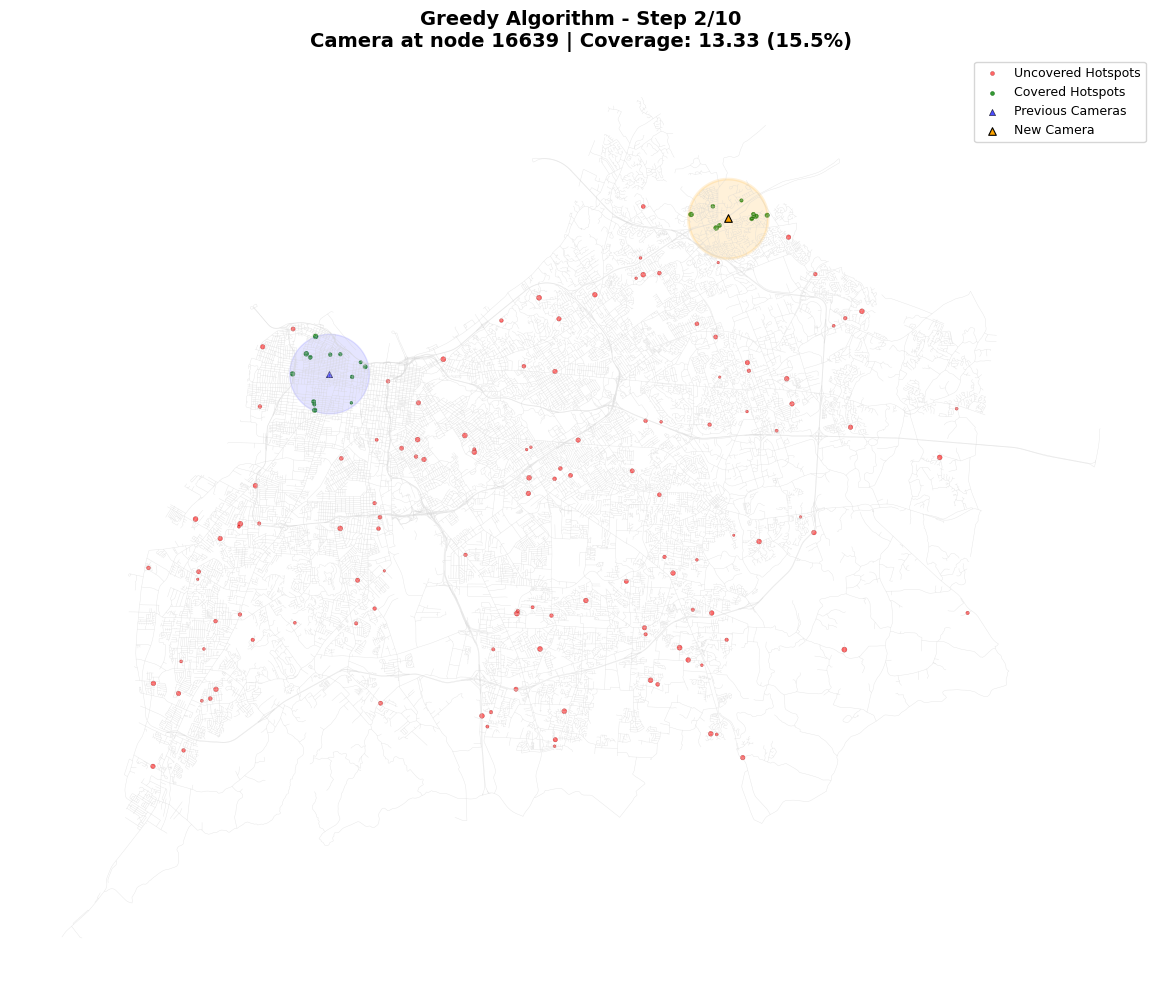

Step 3: Placed camera at node 11665, additional coverage: 4.91, total coverage: 18.25


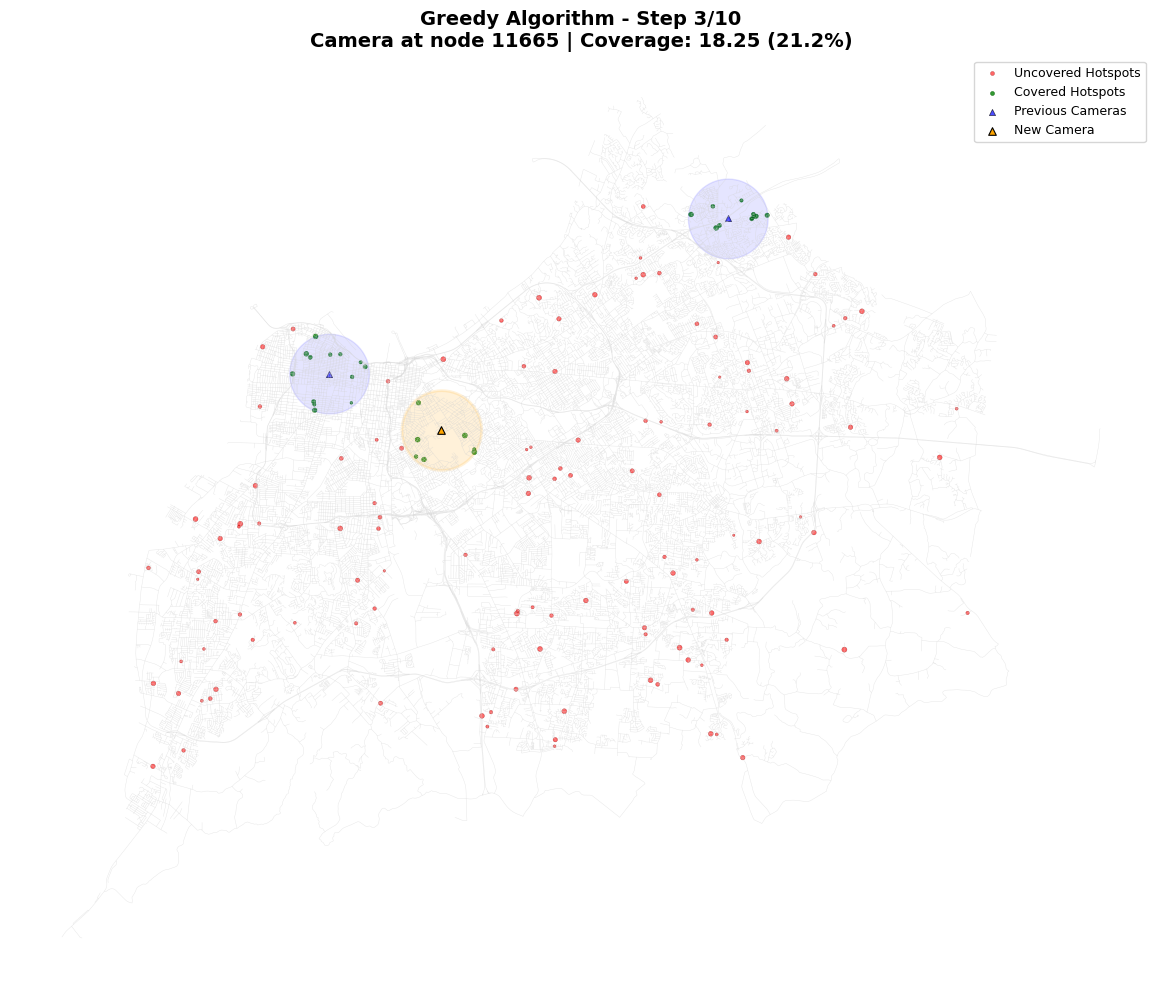

Step 4: Placed camera at node 83, additional coverage: 4.54, total coverage: 22.79


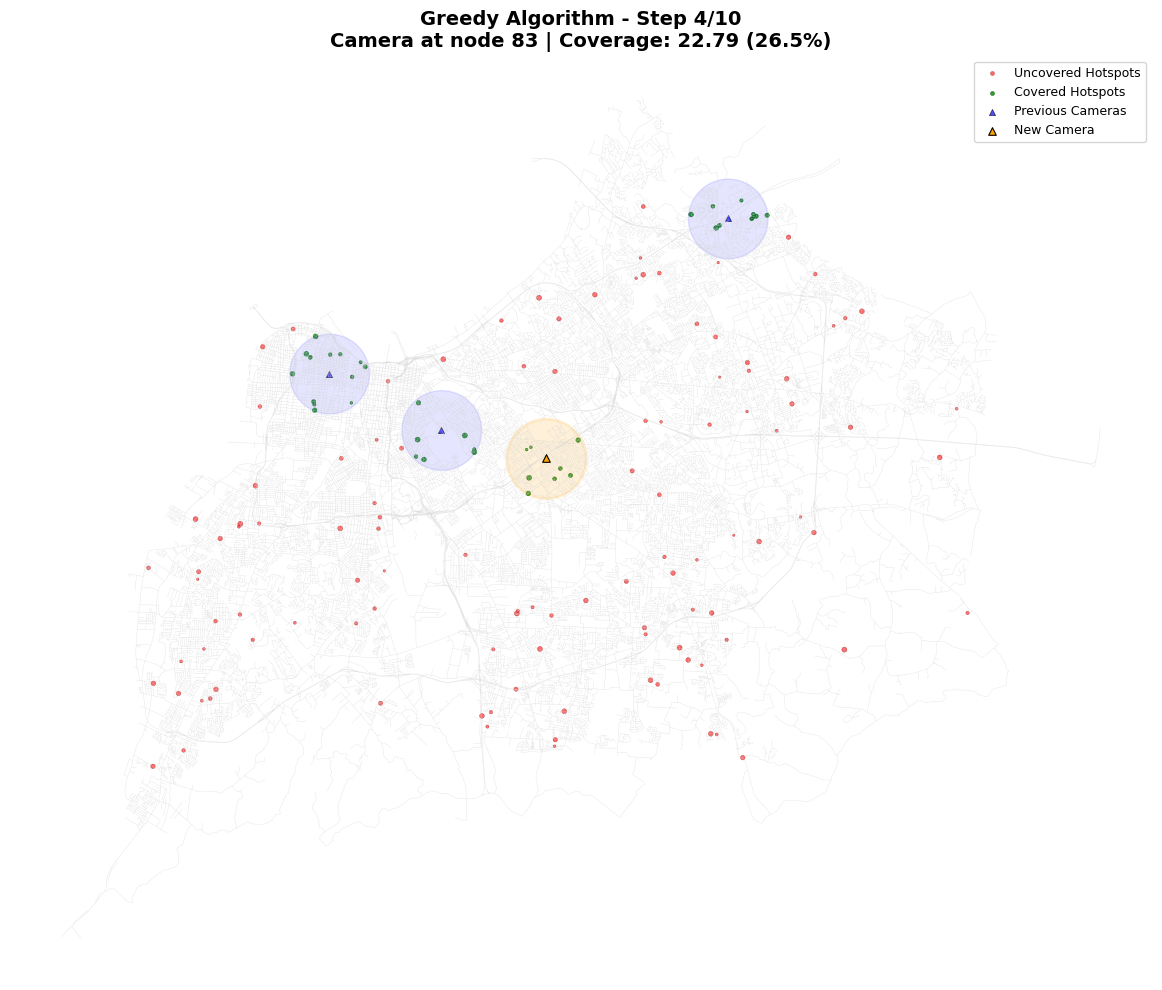

Step 5: Placed camera at node 1634, additional coverage: 4.43, total coverage: 27.22


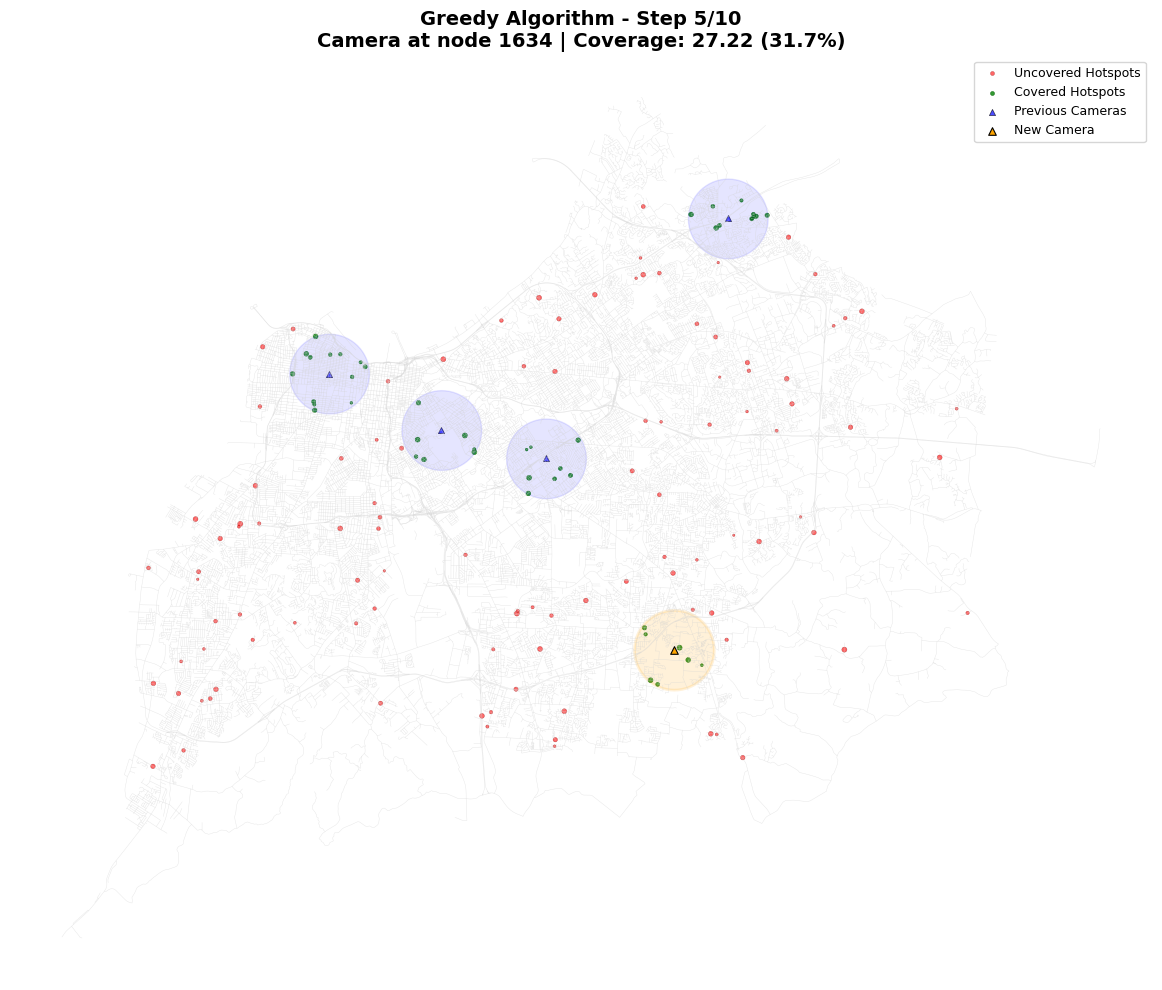

Step 6: Placed camera at node 8341, additional coverage: 4.12, total coverage: 31.34


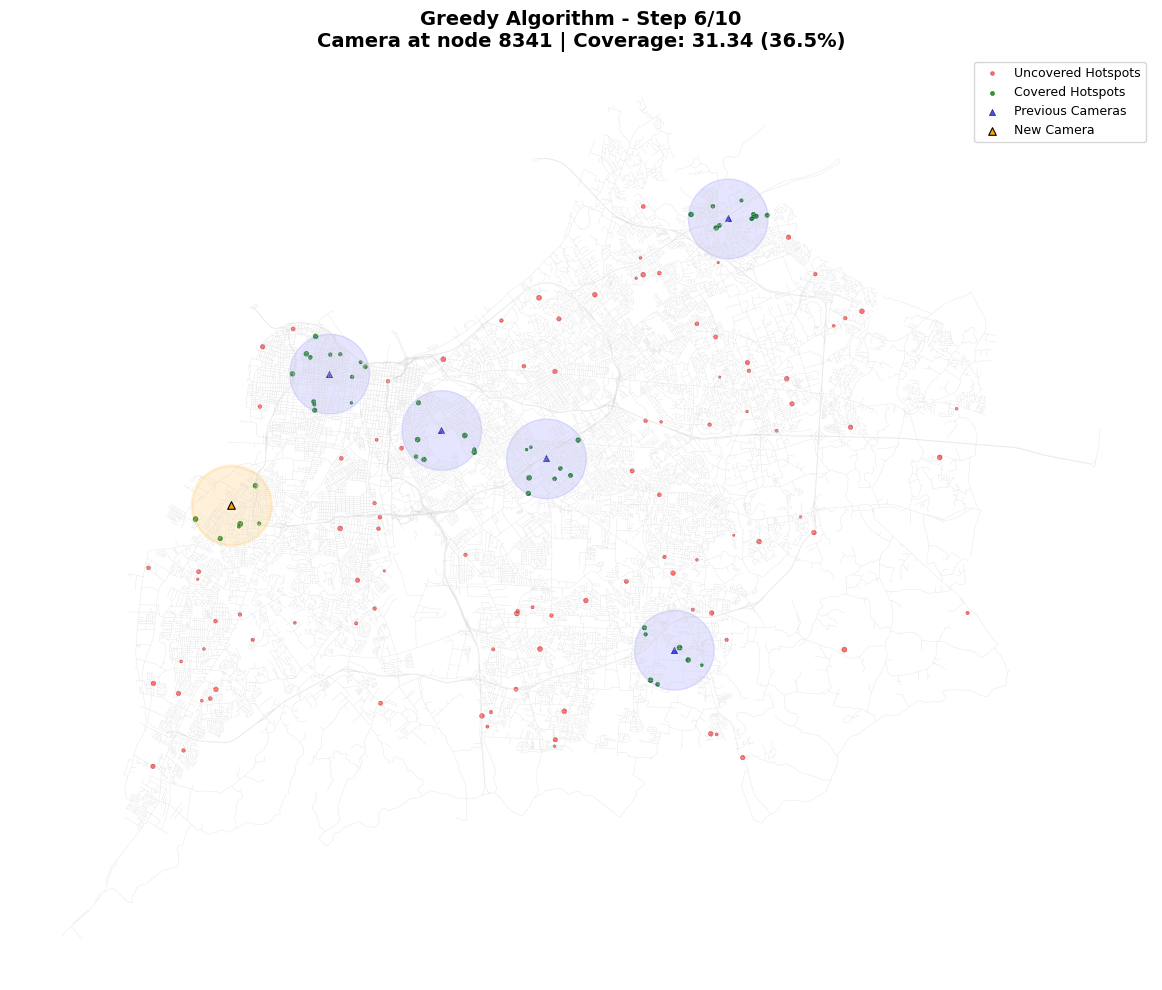

Step 7: Placed camera at node 3568, additional coverage: 3.85, total coverage: 35.19


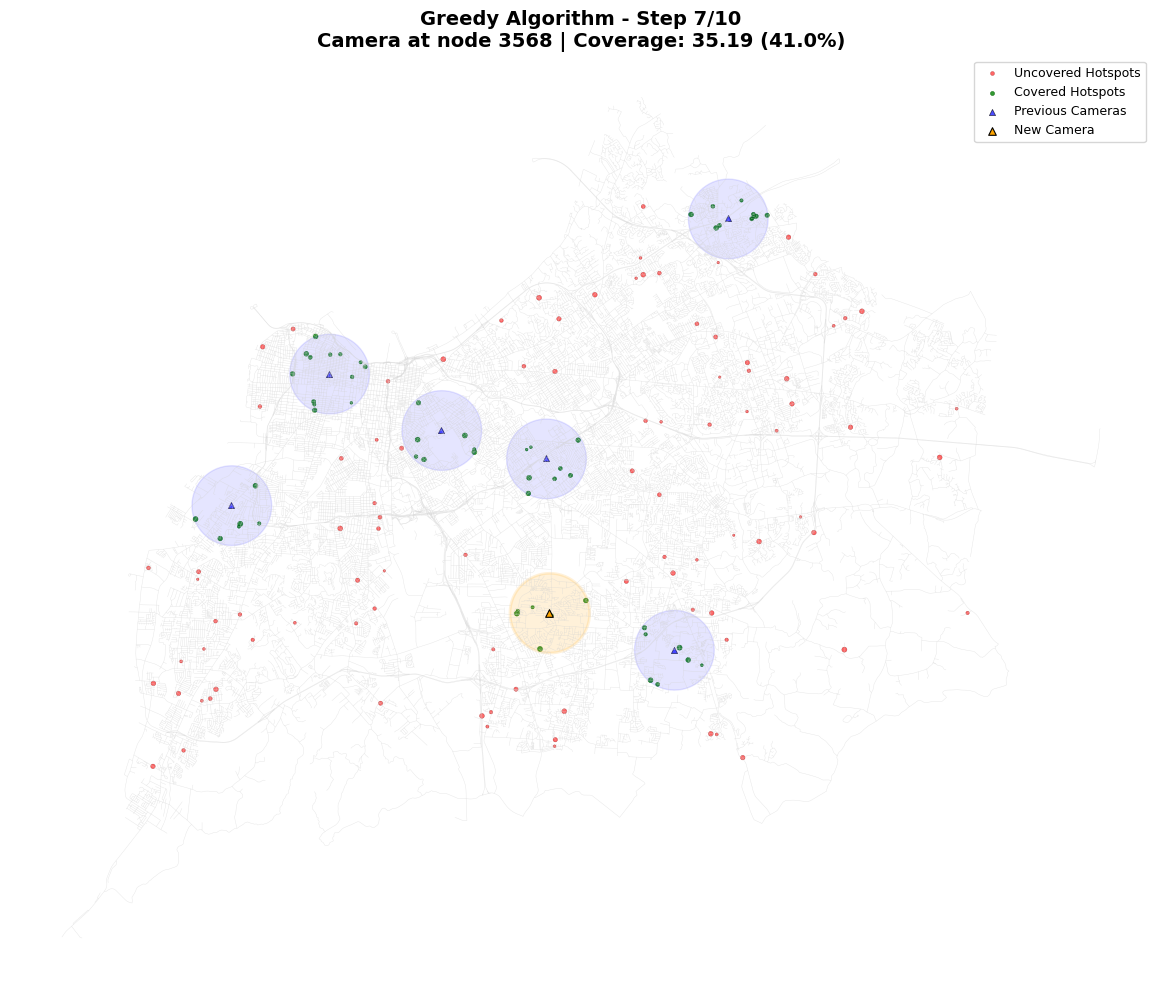

Step 8: Placed camera at node 85, additional coverage: 3.83, total coverage: 39.02


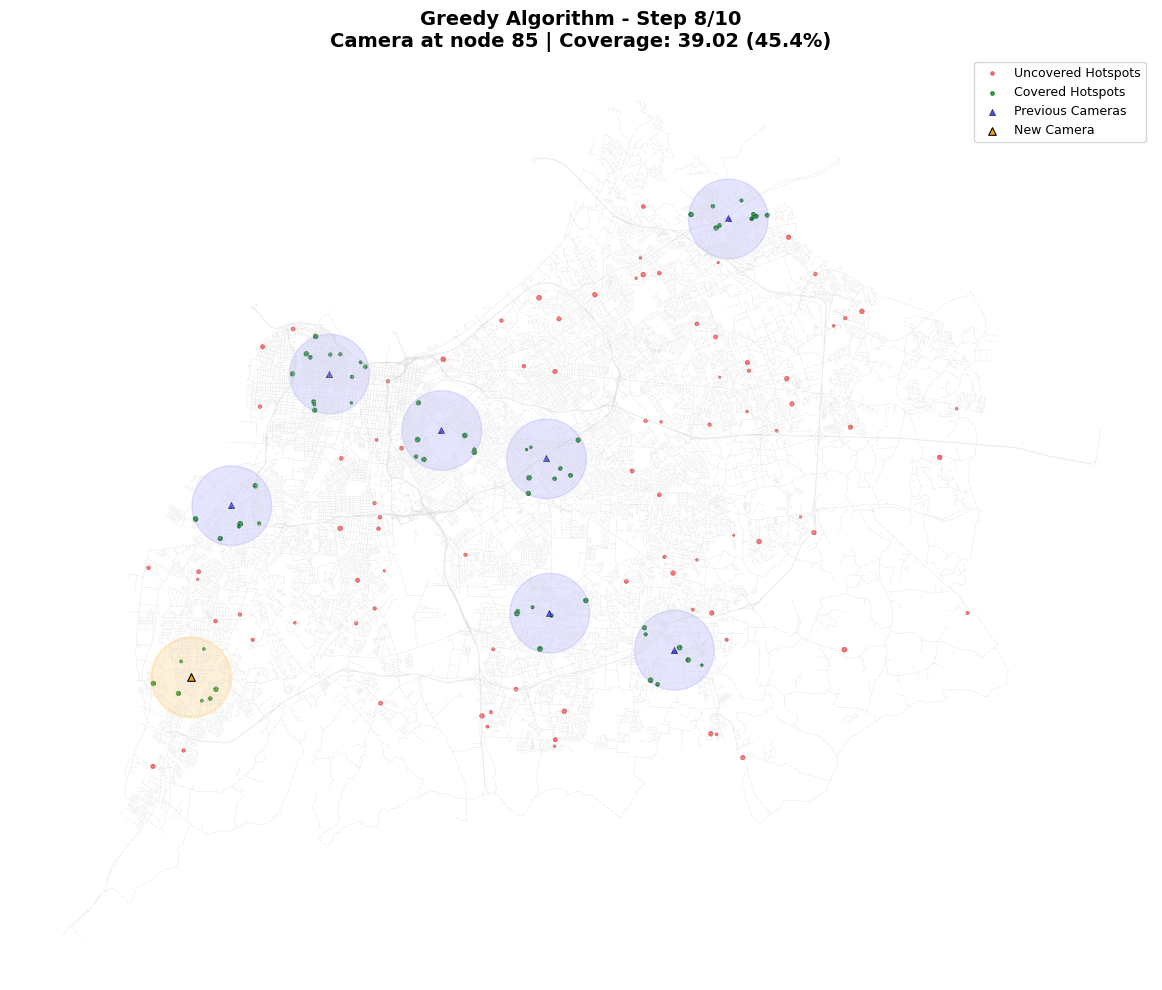

Step 9: Placed camera at node 22662, additional coverage: 3.58, total coverage: 42.59


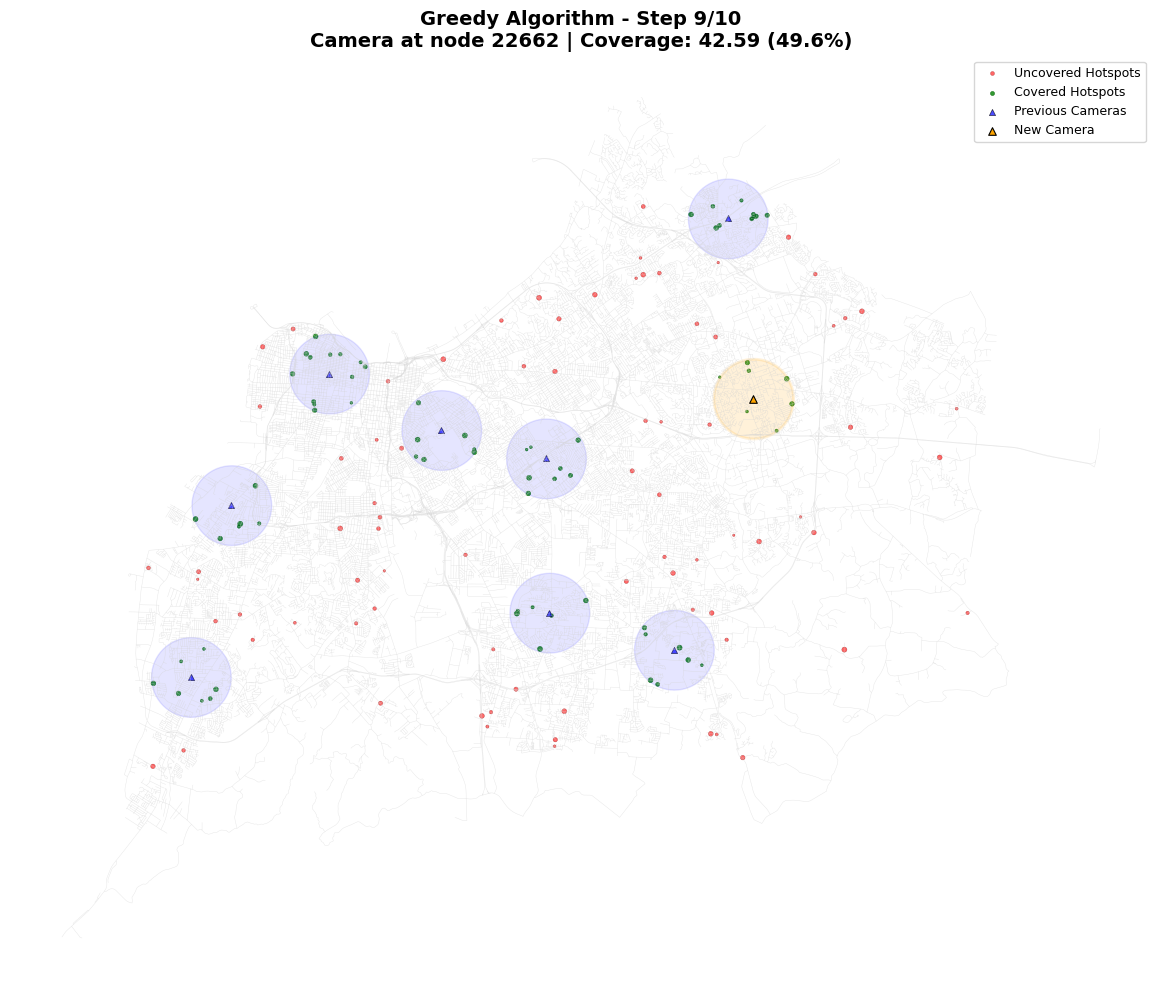

Step 10: Placed camera at node 13691, additional coverage: 2.91, total coverage: 45.50


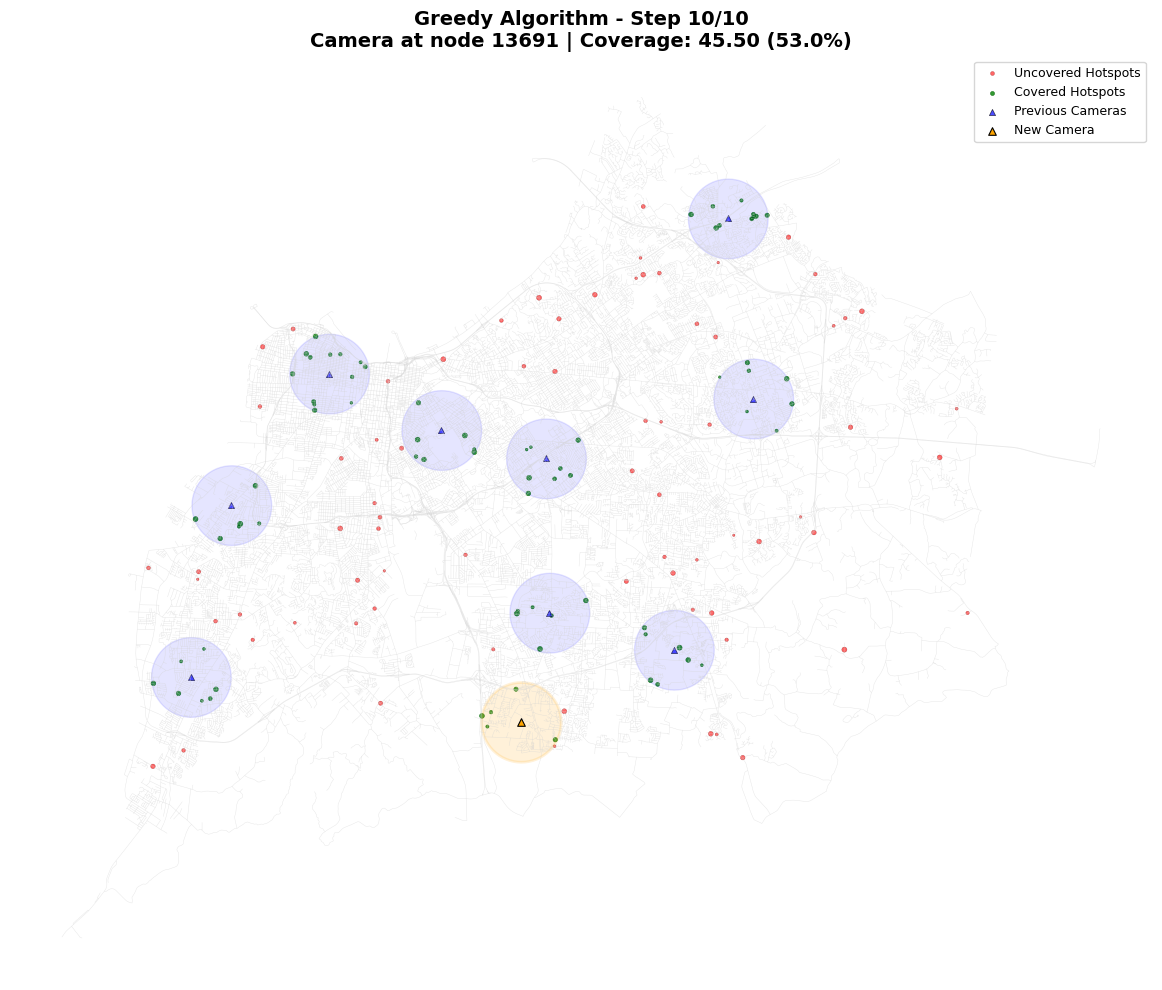


Greedy Algorithm Results:
Cameras placed: 10
Final coverage: 45.50
Maximum possible coverage: 85.89
Coverage percentage: 53.0%
Greedy Algorithm - Coverage Statistics
Hotspot Coverage:
  - Covered Hotspots: 77 / 150
  - Weighted Coverage: 45.50 / 85.89
  - Coverage Percentage: 53.0%

Map Coverage:
  - Area Covered: 125.46 km²
  - Map Coverage Percentage: 5.7%

Creating final comprehensive visualization...
Saved: greedy_final_solution.png


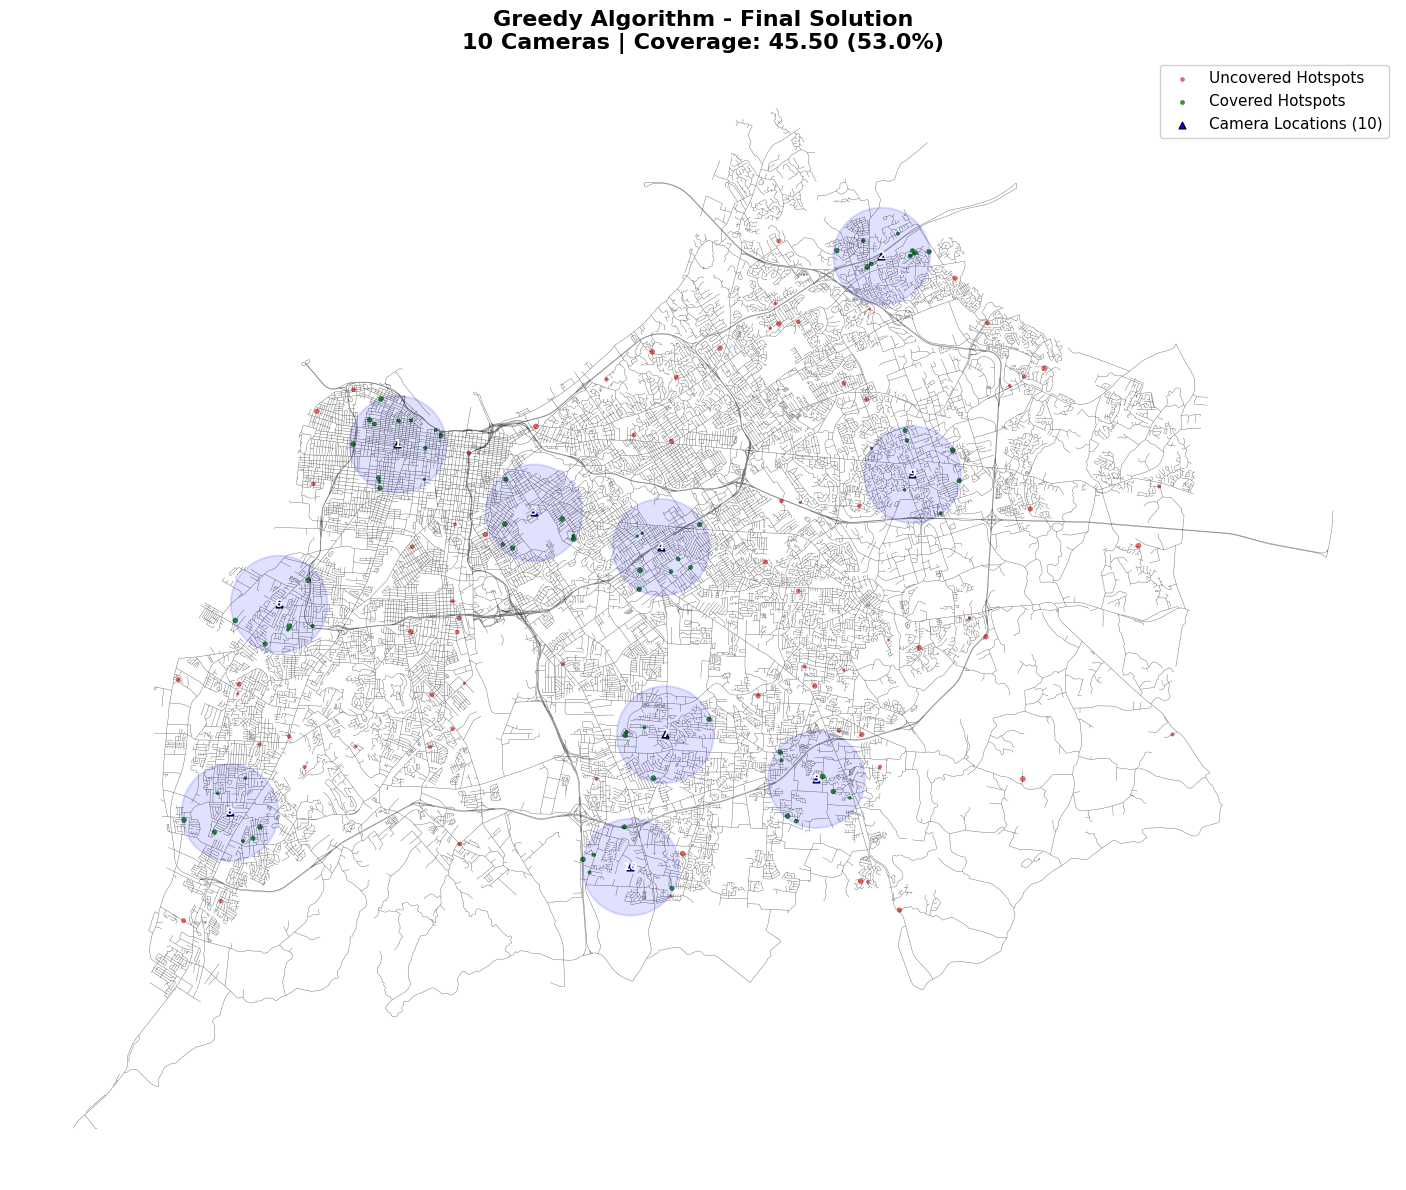

Saved: greedy_coverage_progression.png


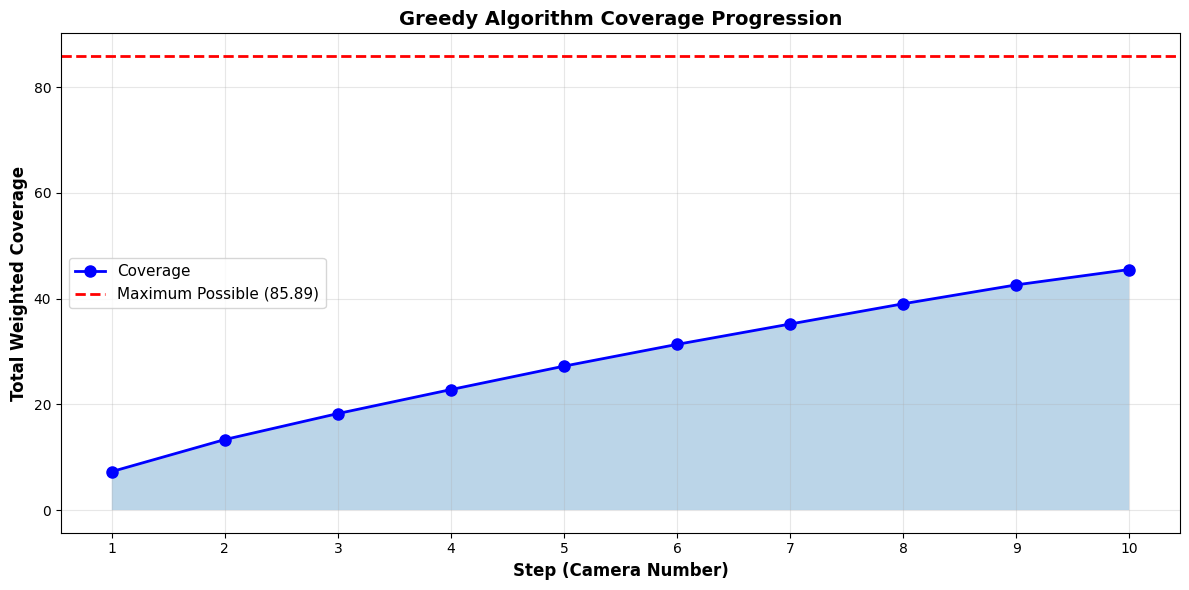

In [18]:
# Section 4: Greedy Algorithm

def greedy_camera_placement(G, num_cameras, coverage_radius_meters, 
                            id_to_point, streets_gdf, hotspots_gdf, visualize_steps=True):
    """
    Greedy algorithm: At each step, place a camera at the node that covers
    the most additional weighted hotspots.
    
    Parameters:
    - G: NetworkX graph
    - num_cameras: number of cameras to place
    - coverage_radius_meters: coverage radius in meters
    - id_to_point: mapping from node ID to coordinates
    - streets_gdf: GeoDataFrame of streets for visualization
    - hotspots_gdf: GeoDataFrame of hotspots for visualization
    - visualize_steps: whether to create step-by-step visualizations
    
    Returns:
    - camera_nodes: list of selected camera node IDs
    - coverage_history: list of coverage values at each step
    - step_visualizations: list of figure objects if visualize_steps=True
    """
    camera_nodes = []
    coverage_history = []
    all_nodes = list(G.nodes())
    step_visualizations = []
    hotspot_weights = hotspots_gdf.risk_weight
    
    node_coverage_cache = create_covered_hotspot_cache(G, id_to_point, hotspots_gdf, coverage_radius_meters)
    
    print(f"Starting greedy selection...")
    
    covered_hotspots = set()
    
    print("\nCreating visualization of hotspots and road network...")
    fig1, ax1 = plt.subplots(figsize=(14, 10))
    streets_gdf.plot(ax=ax1, color='lightgray', linewidth=0.3, alpha=0.6, label='Road Network')
    hotspots_gdf.plot(ax=ax1, color='red', markersize=hotspots_gdf['risk_weight'] * 15, 
                      alpha=0.8, edgecolor='darkred', linewidth=0.5, label='Accident Hotspots')
    ax1.set_title('Louisville Road Network with Accident Hotspots\n(Size indicates risk weight)', 
                  fontsize=14, fontweight='bold')
    ax1.axis('off')
    ax1.legend(loc='upper right', fontsize=10)
    plt.tight_layout()
    plt.savefig('graphs\\hotspots_map.png', dpi=300, bbox_inches='tight')
    print("Saved: hotspots_map.png")
    plt.show()
    
    for step in range(num_cameras):
        best_node = None
        best_additional_coverage = -1
        
        for node in all_nodes:
            if node in camera_nodes:
                continue
            
            node_covered = node_coverage_cache[node]
            new_covered = node_covered - covered_hotspots
            additional_coverage = sum(hotspot_weights[i] for i in new_covered)
            
            if additional_coverage > best_additional_coverage:
                best_additional_coverage = additional_coverage
                best_node = node
        
        if best_node is None:
            break
        
        # Place camera at best location
        camera_nodes.append(best_node)
        covered_hotspots.update(node_coverage_cache[best_node])
        
        # Calculate total coverage
        total_coverage = sum(hotspot_weights[i] for i in covered_hotspots)
        coverage_history.append(total_coverage)
        
        print(f"Step {step + 1}: Placed camera at node {best_node}, "
              f"additional coverage: {best_additional_coverage:.2f}, "
              f"total coverage: {total_coverage:.2f}")
        
        # Create visualization for this step
        if visualize_steps:
            fig, ax = plt.subplots(figsize=(14, 10))
            
            # Plot road network
            streets_gdf.plot(ax=ax, color='lightgray', linewidth=0.3, alpha=0.6)
            
            # Plot all hotspots
            covered_hotspot_indices = list(covered_hotspots)
            uncovered_hotspot_indices = [i for i in range(len(hotspots_gdf)) if i not in covered_hotspots]
            
            if uncovered_hotspot_indices:
                hotspots_gdf.iloc[uncovered_hotspot_indices].plot(
                    ax=ax, color='red', markersize=hotspots_gdf.iloc[uncovered_hotspot_indices]['risk_weight'] * 15,
                    alpha=0.6, edgecolor='darkred', linewidth=0.3, label='Uncovered Hotspots'
                )
            
            if covered_hotspot_indices:
                hotspots_gdf.iloc[covered_hotspot_indices].plot(
                    ax=ax, color='green', markersize=hotspots_gdf.iloc[covered_hotspot_indices]['risk_weight'] * 15,
                    alpha=0.8, edgecolor='darkgreen', linewidth=0.4, label='Covered Hotspots'
                )
            
            # Plot existing cameras
            if len(camera_nodes) > 1:
                existing_cameras = camera_nodes[:-1]
                existing_camera_points = [Point(id_to_point[node_id]) for node_id in existing_cameras]
                existing_cameras_gdf = gpd.GeoDataFrame(geometry=existing_camera_points, crs=streets_gdf.crs)
                existing_cameras_gdf.plot(ax=ax, color='blue', markersize=20, marker='^', 
                                         edgecolor='black', linewidth=0.5, alpha=0.7, label='Previous Cameras')
            
            # Plot new camera
            new_camera_point = Point(id_to_point[best_node])
            new_camera_gdf = gpd.GeoDataFrame(geometry=[new_camera_point], crs=streets_gdf.crs)
            new_camera_gdf.plot(ax=ax, color='orange', markersize=30, marker='^', 
                               edgecolor='black', linewidth=0.8, label='New Camera', zorder=10)
            
            # Draw coverage circle for new camera
            vis_radius = coverage_radius_meters
            circle = new_camera_point.buffer(vis_radius)
            gpd.GeoSeries([circle], crs=streets_gdf.crs).plot(ax=ax, color='orange', 
                                                              alpha=0.15, edgecolor='orange', linewidth=2)
            
            # Draw coverage circles for existing camera
            for existing_camera_point in existing_camera_points if len(camera_nodes) > 1 else []:
                circle = existing_camera_point.buffer(vis_radius)
                gpd.GeoSeries([circle], crs=streets_gdf.crs).plot(ax=ax, color='blue', 
                                                                 alpha=0.1, edgecolor='blue', linewidth=1)
            
            ax.set_title(f'Greedy Algorithm - Step {step + 1}/{num_cameras}\n'
                        f'Camera at node {best_node} | Coverage: {total_coverage:.2f} ({100 * total_coverage / sum(hotspot_weights):.1f}%)',
                        fontsize=14, fontweight='bold')
            ax.axis('off')
            ax.legend(loc='upper right', fontsize=9)
            plt.tight_layout()
            
            if step < 5:  # Saves first 5 steps to show
                plt.savefig(f'graphs\\greedy_step_{step + 1}.png', dpi=300, bbox_inches='tight')
            
            step_visualizations.append(fig)
            plt.show()
    
    return camera_nodes, coverage_history, step_visualizations

# Run Greedy Algorithm
print("=" * 60)
print("GREEDY ALGORITHM")
print("=" * 60)

greedy_cameras, greedy_coverage_history, greedy_plots = greedy_camera_placement(
    G, NUM_CAMERAS, COVERAGE_RADIUS,
    id_to_point, streets_gdf, hotspots_gdf, visualize_steps=True
)

print(f"\nGreedy Algorithm Results:")
print(f"Cameras placed: {len(greedy_cameras)}")
print(f"Final coverage: {greedy_coverage_history[-1]:.2f}")
print(f"Maximum possible coverage: {sum(hotspot_weights):.2f}")
print(f"Coverage percentage: {100 * greedy_coverage_history[-1] / sum(hotspot_weights):.1f}%")

# Print comprehensive coverage statistics
greedy_stats = print_coverage_stats(
    greedy_cameras, hotspots_gdf, 
    COVERAGE_RADIUS, id_to_point, streets_gdf, "Greedy Algorithm"
)

# Final comprehensive visualization
print("\nCreating final comprehensive visualization...")
fig_final, ax_final = plt.subplots(figsize=(16, 12))

# Plot road network
streets_gdf.plot(ax=ax_final, color='black', linewidth=0.3, alpha=0.6)

# Determine covered vs uncovered hotspots
final_coverage, final_covered_hotspots = calculate_coverage(
    greedy_cameras, id_to_point, hotspots_gdf, COVERAGE_RADIUS
)
covered_hotspot_indices = final_covered_hotspots
uncovered_hotspot_indices = [i for i in range(len(hotspots_gdf)) if i not in covered_hotspot_indices]

# Plot uncovered hotspots
if uncovered_hotspot_indices:
    hotspots_gdf.iloc[uncovered_hotspot_indices].plot(
        ax=ax_final, color='red', markersize=hotspots_gdf.iloc[uncovered_hotspot_indices]['risk_weight'] * 15,
        alpha=0.6, edgecolor='darkred', linewidth=0.3, label='Uncovered Hotspots'
    )

# Plot covered hotspots
if covered_hotspot_indices:
    hotspots_gdf.iloc[covered_hotspot_indices].plot(
        ax=ax_final, color='green', markersize=hotspots_gdf.iloc[covered_hotspot_indices]['risk_weight'] * 15,
        alpha=0.8, edgecolor='darkgreen', linewidth=0.4, label='Covered Hotspots'
    )

# Plot all cameras with coverage circles
greedy_camera_points = [Point(id_to_point[node_id]) for node_id in greedy_cameras]
greedy_cameras_gdf = gpd.GeoDataFrame(geometry=greedy_camera_points, crs=streets_gdf.crs)

# Draw coverage circles first so they appear behind cameras
vis_radius = COVERAGE_RADIUS
for i, camera_point in enumerate(greedy_camera_points):
    circle = camera_point.buffer(vis_radius)
    gpd.GeoSeries([circle], crs=streets_gdf.crs).plot(ax=ax_final, color='blue', 
                                                      alpha=0.12, edgecolor='blue', linewidth=1.5)

# Plot cameras
greedy_cameras_gdf.plot(ax=ax_final, color='blue', markersize=25, marker='^', 
                       edgecolor='black', linewidth=0.8, label=f'Camera Locations ({len(greedy_cameras)})', zorder=10)

for i, (node_id, point) in enumerate(zip(greedy_cameras, greedy_camera_points)):
    ax_final.annotate(f'{i+1}', xy=(point.x, point.y), fontsize=8, fontweight='bold',
                     ha='center', va='center', color='white', zorder=11)

ax_final.set_title(f'Greedy Algorithm - Final Solution\n'
                  f'{len(greedy_cameras)} Cameras | Coverage: {greedy_coverage_history[-1]:.2f} '
                  f'({100 * greedy_coverage_history[-1] / sum(hotspot_weights):.1f}%)',
                  fontsize=16, fontweight='bold')
ax_final.axis('off')
ax_final.legend(loc='upper right', fontsize=11, framealpha=0.9)
plt.tight_layout()
plt.savefig('graphs\\greedy_final_solution.png', dpi=300, bbox_inches='tight')
print("Saved: greedy_final_solution.png")
plt.show()

# Plot coverage progression
fig_prog, ax_prog = plt.subplots(figsize=(12, 6))
steps = range(1, len(greedy_coverage_history) + 1)
ax_prog.plot(steps, greedy_coverage_history, 'b-o', linewidth=2, markersize=8, label='Coverage')
ax_prog.axhline(y=sum(hotspot_weights), color='r', linestyle='--', linewidth=2, 
               label=f'Maximum Possible ({sum(hotspot_weights):.2f})')
ax_prog.fill_between(steps, greedy_coverage_history, alpha=0.3)
ax_prog.set_xlabel('Step (Camera Number)', fontsize=12, fontweight='bold')
ax_prog.set_ylabel('Total Weighted Coverage', fontsize=12, fontweight='bold')
ax_prog.set_title('Greedy Algorithm Coverage Progression', fontsize=14, fontweight='bold')
ax_prog.grid(True, alpha=0.3)
ax_prog.legend(fontsize=11)
ax_prog.set_xticks(steps)
plt.tight_layout()
plt.savefig('graphs\\greedy_coverage_progression.png', dpi=300, bbox_inches='tight')
print("Saved: greedy_coverage_progression.png")
plt.show()


In [19]:
import copy

class Schedule():
    def __init__(self, method="exponential", alpha=0.95, starting_temp=1000):
        self.method = method
        self.alpha = alpha
        self.T_0 = starting_temp

        def exponential_cool(self, k):
            # Assumes alpha is a constant 0.8 <= alpha <= 0.9
            return self.T_0 * (self.alpha**k)
        
        def logarithmic_cool(self, k):
            # Assumes alpha is a constant greater than 1
            return self.T_0 / (1 + self.alpha * np.log(1 + k))
        
        def linear_cool(self, k):
            # Assumes alpha is a constant greater than zero
            return self.T_0 / (1 + self.alpha*k)
        
        self.cool_fn = linear_cool
        if method == "exponential":
            self.cool_fn = exponential_cool
        elif method == "logarithmic":
            self.cool_fn = logarithmic_cool

    def cool(self, k):
        return self.cool_fn(self, k)
        
def generate_random_solution(covering_nodes, num_cameras) -> list:
    return list(np.random.choice(covering_nodes, size=num_cameras, replace=False))
    
def weighted_coverage(camera_nodes, hotspot_cache, hotspots_gdf):
    covered_hotspots = set()

    for n in camera_nodes:
        covered_hotspots.update(hotspot_cache[n])

    hotspot_weights = hotspots_gdf.risk_weight
    total_coverage = sum(hotspot_weights[i] for i in covered_hotspots)
    return total_coverage

def pick_next_solution(covering_nodes, current) -> list:
    camera = np.random.choice(current)
    
    next_camera = np.random.choice(covering_nodes)

    next = copy.deepcopy(current)
    next.remove(camera)
    next.append(next_camera)
    return next

def simulated_annealing_camera_placement(G, num_cameras, coverage_radius_meters, 
                            id_to_point, hotspots_gdf,
                            hotspot_cache=None,
                            save_steps=True, schedule=Schedule(),
                            stop_temp= 1e-5, max_iters = 100000):

    saved_bests = []
    coverage_history = []

    if hotspot_cache == None:
        hotspot_cache = create_covered_hotspot_cache(G, id_to_point, hotspots_gdf, coverage_radius_meters)

    covering_nodes = []
    for node, coverage in hotspot_cache.items():
        if coverage:
            covering_nodes.append(node)

    current = generate_random_solution(covering_nodes, num_cameras)
    current_coverage = weighted_coverage(current, hotspot_cache, hotspots_gdf)

    best_solution = copy.deepcopy(current)
    best_coverage = current_coverage


    t = schedule.T_0
    k = 0
    if save_steps:
        saved_bests.append((best_solution, k))

    while k < max_iters and t > stop_temp:
        t = schedule.cool(k)
        k += 1

        candidate = pick_next_solution(covering_nodes, current)
        candidate_coverage = weighted_coverage(candidate, hotspot_cache, hotspots_gdf)

        if save_steps:
            coverage_history.append(candidate_coverage)

        if candidate_coverage > current_coverage:
            current = candidate
            current_coverage = candidate_coverage
            
            if candidate_coverage > best_coverage:
                best_solution = copy.deepcopy(candidate)
                best_coverage = candidate_coverage

                if save_steps:
                    saved_bests.append((best_solution, k))
        else:
            prob = np.exp((candidate_coverage - current_coverage) / t)
            r = np.random.uniform(0,1)
            if prob > r:
                current = candidate
                current_coverage = candidate_coverage

    return best_solution, best_coverage, k, saved_bests, coverage_history

In [20]:
vary_params = False

if vary_params:
    cache = create_covered_hotspot_cache(G, id_to_point, hotspots_gdf, COVERAGE_RADIUS)

    params = [
        ("exponential", np.linspace(start=.8, stop=.99, num=25), np.linspace(start=1000, stop=100000, num=10)),
        ("linear", np.linspace(start=.1, stop=2, num=25), [1000, 2000]),
        ("logarithmic", np.linspace(start=1.1, stop=10, num=25), [1000, 2000])
    ]
    
    best_coverage = -np.inf
    best_params = None
    best_solution = None
    for (method, alphas, t_0s) in params:
        for t0 in t_0s:
            for alpha in alphas:
                schedule = Schedule(method=method, alpha=alpha, starting_temp=t0)

                annealing_cameras, coverage, k, saved_bests, coverage_history = simulated_annealing_camera_placement(G, NUM_CAMERAS, COVERAGE_RADIUS, 
                                        id_to_point, hotspots_gdf, visualize_steps=True, max_iters=10000,
                                        hotspot_cache=cache, schedule=schedule)

                if coverage > best_coverage:
                    best_solution = annealing_cameras
                    best_coverage = coverage
                    best_params = (method, alpha, k)

                    (method, alpha, k) = best_params
                    print("Best solution: {}".format(best_solution))
                    print("With Coverage: {}".format(best_coverage))
                    print("Method: {} Alpha: {} Iters: {} Temp: {}\n".format(method, alpha, k, t0))
            

In [21]:
def plot_simulated_annealing(camera_placements, hotspot_cache, hotspots_gdf, k, total_coverage, coverage_radius_meters, step_visualizations):
    fig, ax = plt.subplots(figsize=(14, 10))
    vis_radius = coverage_radius_meters

    # Plot road network
    streets_gdf.plot(ax=ax, color='lightgray', linewidth=0.3, alpha=0.6)
    
    # Plot all hotspots
    covered_hotspot_indicies = set()
    for n in camera_placements:
        covered_hotspot_indicies.update(hotspot_cache[n])
    uncovered_hotspot_indices = [i for i in range(len(hotspots_gdf)) if i not in covered_hotspot_indicies]
    
    if uncovered_hotspot_indices:
        hotspots_gdf.iloc[uncovered_hotspot_indices].plot(
            ax=ax, color='red', markersize=hotspots_gdf.iloc[uncovered_hotspot_indices]['risk_weight'] * 15,
            alpha=0.6, edgecolor='darkred', linewidth=0.3, label='Uncovered Hotspots'
        )
    
    if covered_hotspot_indices:
        hotspots_gdf.iloc[covered_hotspot_indices].plot(
            ax=ax, color='green', markersize=hotspots_gdf.iloc[covered_hotspot_indices]['risk_weight'] * 15,
            alpha=0.8, edgecolor='darkgreen', linewidth=0.4, label='Covered Hotspots'
        )

    # Plot cameras
    camera_points = [Point(id_to_point[node_id]) for node_id in camera_placements]
    cameras_gdf = gpd.GeoDataFrame(geometry=camera_points, crs=streets_gdf.crs)
    cameras_gdf.plot(ax=ax, color='blue', markersize=20, marker='^', 
                                edgecolor='black', linewidth=0.5, alpha=0.7, label='Camera Placements')
    
    # Draw coverage circles for cameras
    for camera_point in camera_points:
        circle = camera_point.buffer(vis_radius)
        gpd.GeoSeries([circle], crs=streets_gdf.crs).plot(ax=ax, color='blue', 
                                                            alpha=0.1, edgecolor='blue', linewidth=1)
    
    ax.set_title(f'Simulated Annealing Algorithm - Step {k + 1}\n'
                f'| Coverage: {total_coverage:.2f} ({100 * total_coverage / sum(hotspot_weights):.1f}%)',
                fontsize=14, fontweight='bold')
    ax.axis('off')
    ax.legend(loc='upper right', fontsize=9)
    plt.tight_layout()
    
    plt.savefig(f'graphs\\annealing_step_{k+1}.png', dpi=300, bbox_inches='tight')
    
    step_visualizations.append(fig)
    plt.show()

def plot_coverage_progression(coverage_history, hotspots_gdf):
    hotspot_weights = hotspots_gdf.risk_weight

    fig_prog, ax_prog = plt.subplots(figsize=(12, 6))
    steps = range(1, len(coverage_history) + 1)
    ax_prog.plot(steps, coverage_history, 'b-o', linewidth=2, markersize=8, label='Coverage')
    ax_prog.axhline(y=sum(hotspot_weights), color='r', linestyle='--', linewidth=2, 
                label=f'Maximum Possible ({sum(hotspot_weights):.2f})')
    ax_prog.fill_between(steps, coverage_history, alpha=0.3)
    ax_prog.set_xlabel('Iteration', fontsize=12, fontweight='bold')
    ax_prog.set_ylabel('Total Weighted Coverage', fontsize=12, fontweight='bold')
    ax_prog.set_title('Annealing Algorithm Coverage Progression', fontsize=14, fontweight='bold')
    ax_prog.grid(True, alpha=0.3)
    ax_prog.legend(fontsize=11)
    ax_prog.set_xticks(steps)
    plt.tight_layout()
    plt.savefig('graphs\\annealing_coverage_progression.png', dpi=300, bbox_inches='tight')
    print("Saved: annealing_coverage_progression.png")
    plt.show()

In [22]:
# Run Simulated Annealing Algorithm
print("=" * 60)
print("SIMULATED ANNEALING ALGORITHM")
print("=" * 60)

should_graph = True

print("Starting Annealing")
hotspot_cache = create_covered_hotspot_cache(G, id_to_point, hotspots_gdf, COVERAGE_RADIUS)
annealing_cameras, coverage, _, saved_bests, coverage_history = simulated_annealing_camera_placement(G, NUM_CAMERAS, COVERAGE_RADIUS, 
                            id_to_point, hotspots_gdf, save_steps=should_graph,
                            max_iters= 10000, hotspot_cache=hotspot_cache,
                            schedule=Schedule(method="linear", starting_temp=1000, alpha=1.525))

print("Finished Annealing")
print("Placements: {}".format(annealing_cameras))
print("Coverage: {}".format(coverage))

SIMULATED ANNEALING ALGORITHM
Starting Annealing
Finished Annealing
Placements: [np.int64(18546), np.int64(1582), np.int64(15527), np.int64(21036), np.int64(21142), np.int64(13584), np.int64(347), np.int64(14848), np.int64(24441), np.int64(10449)]
Coverage: 42.680324393634926


Generating Graphs


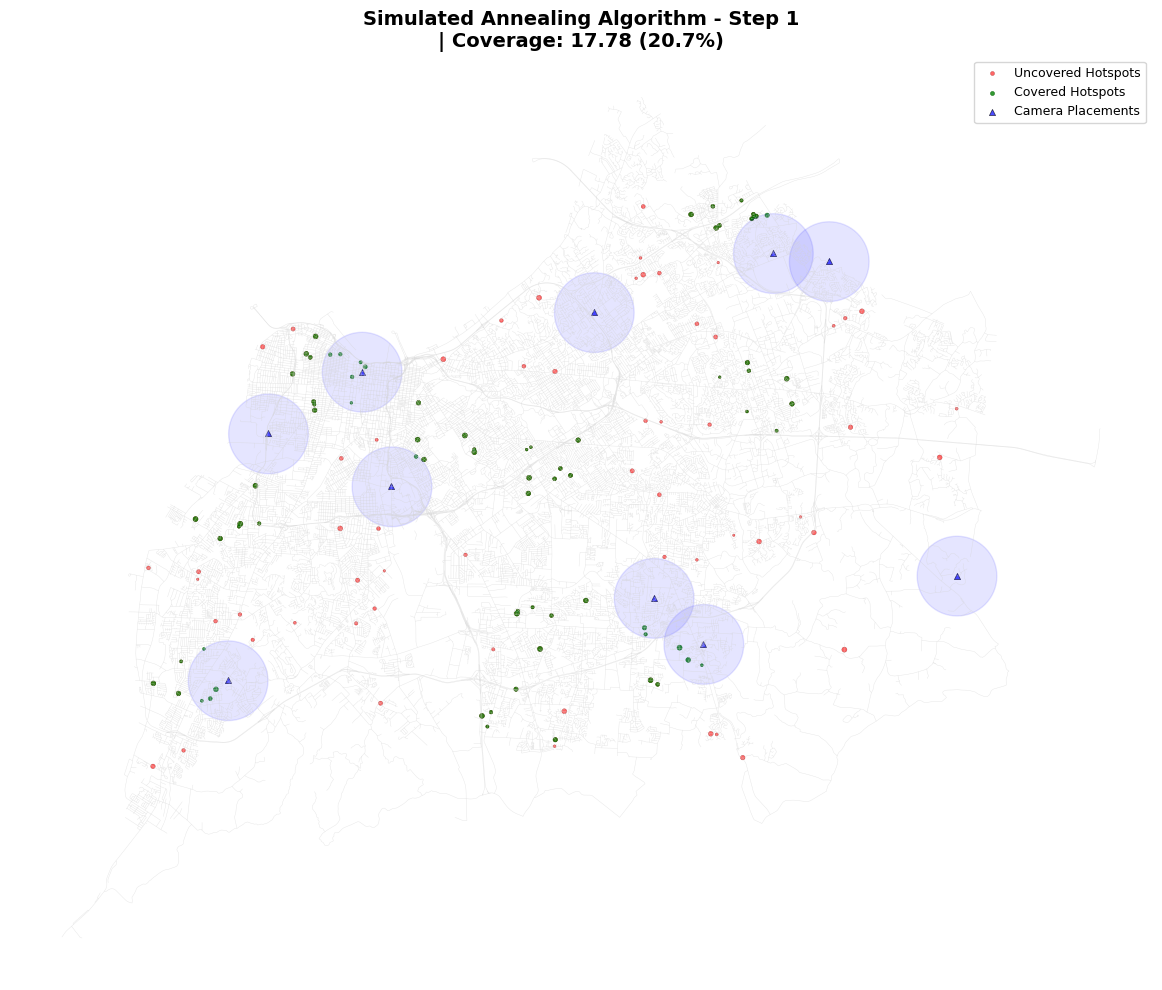

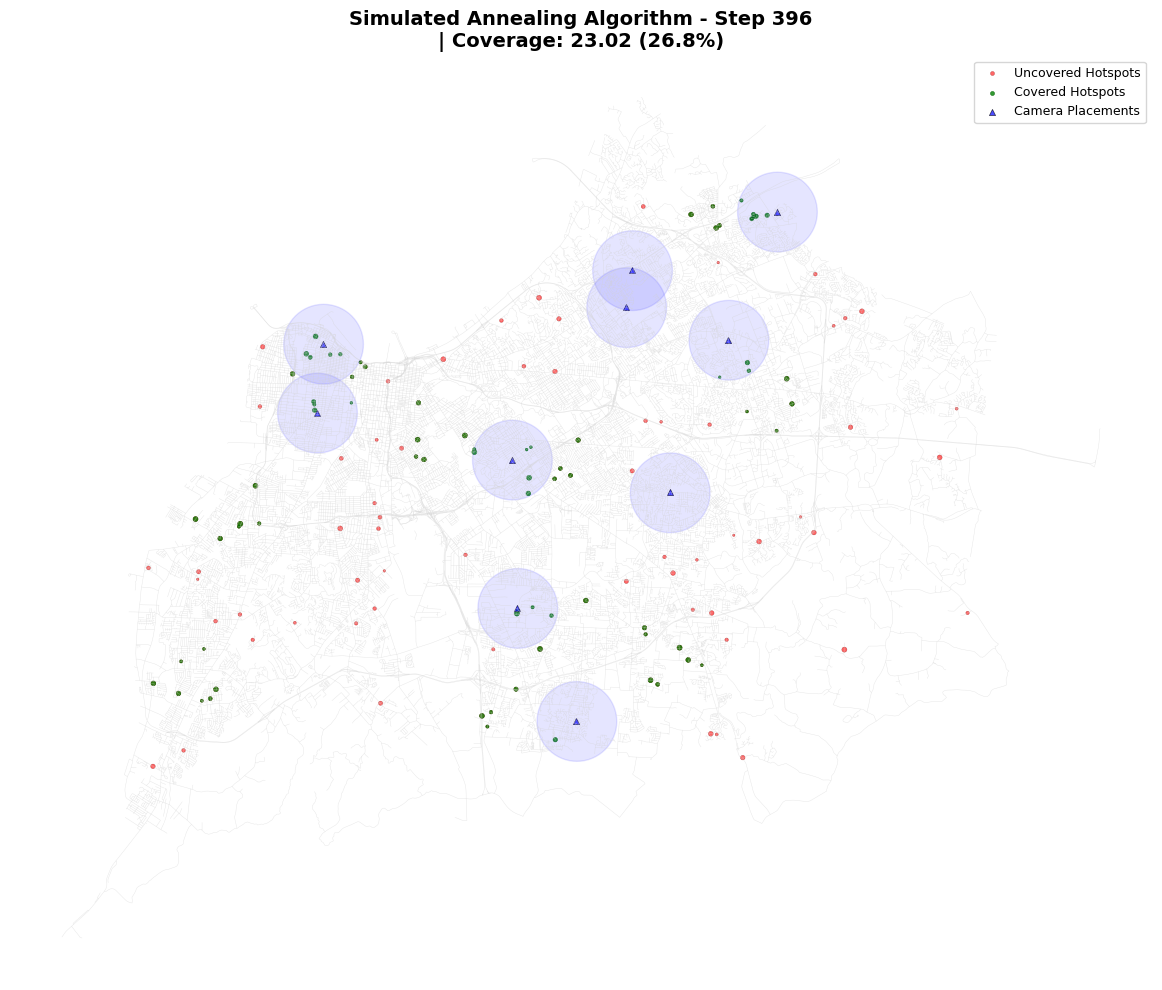

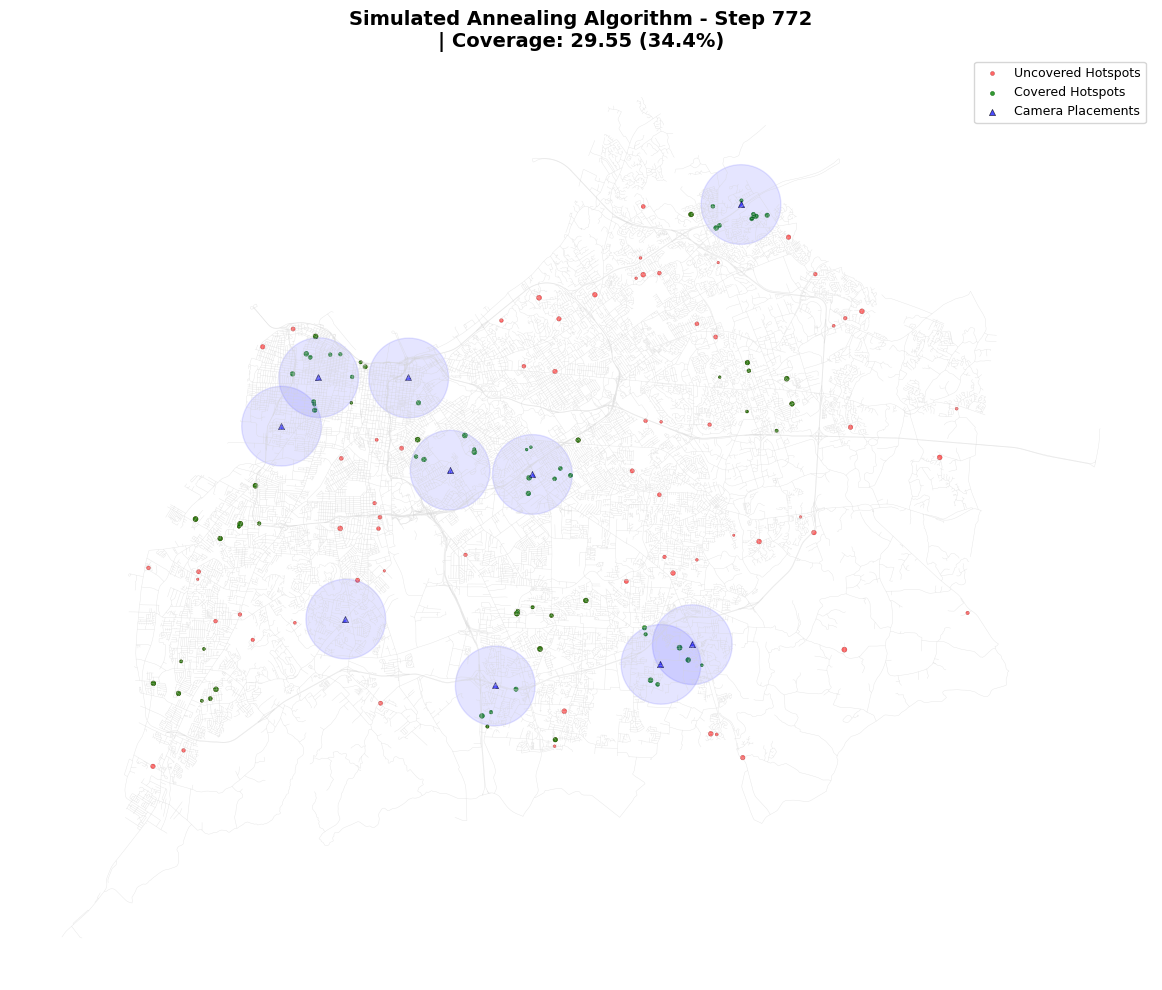

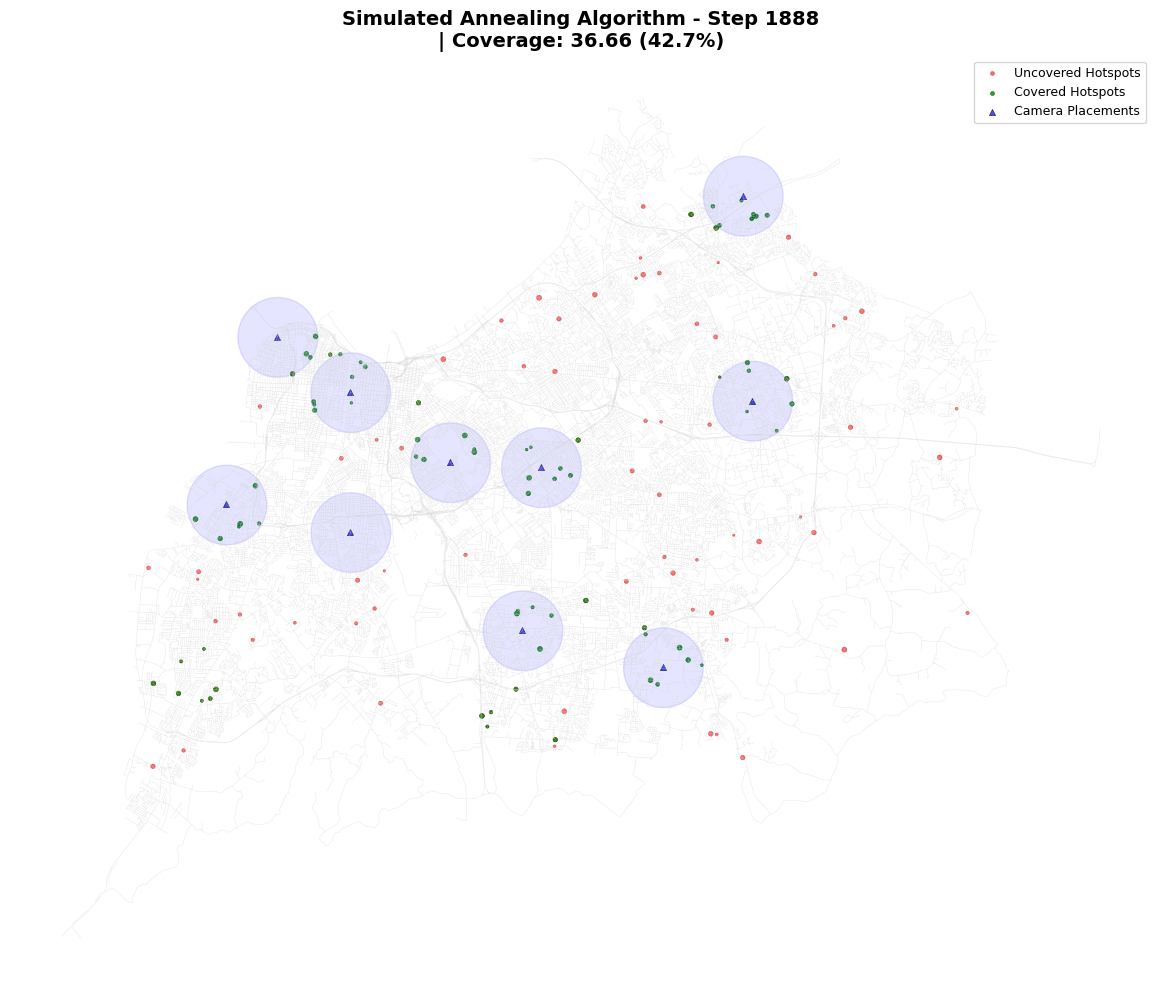

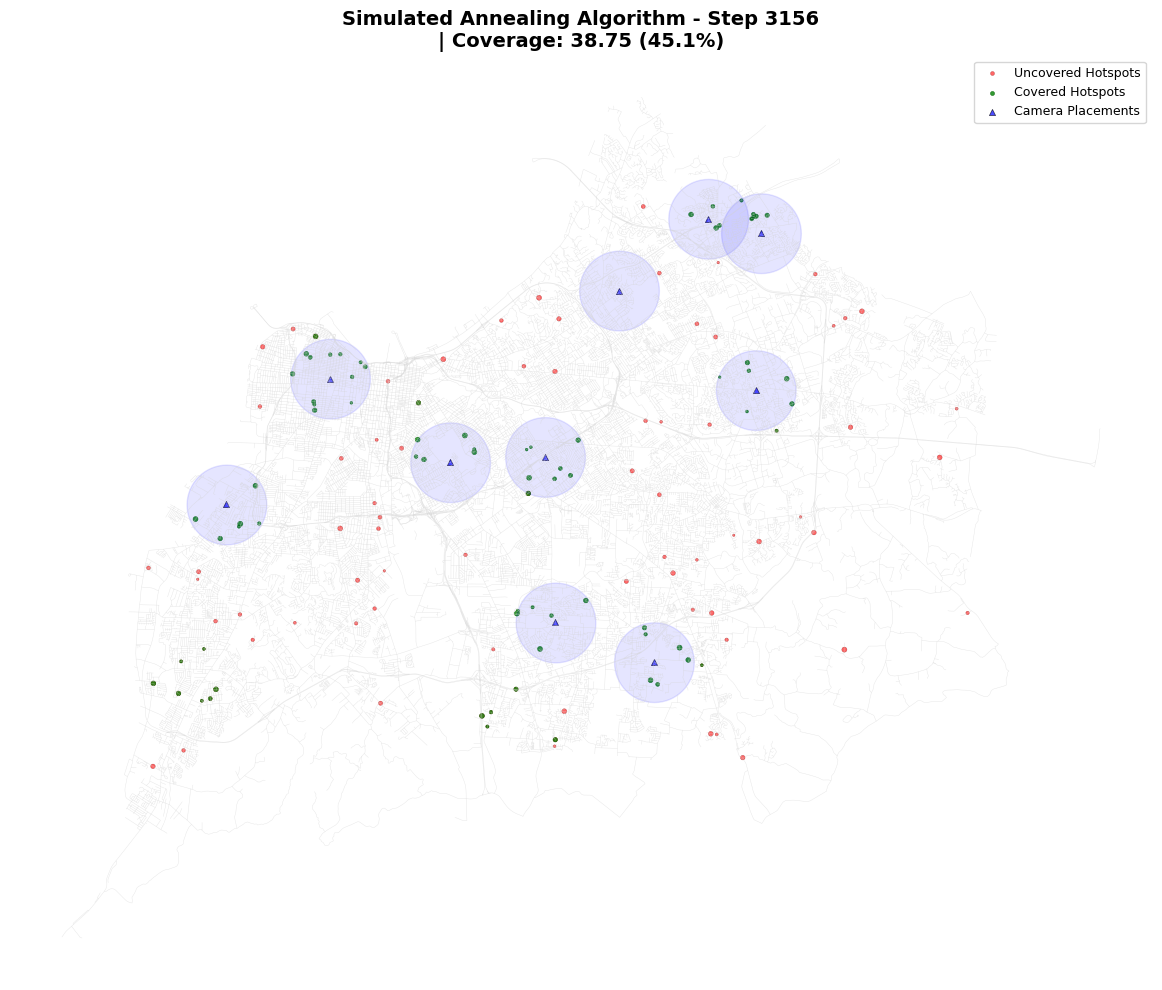

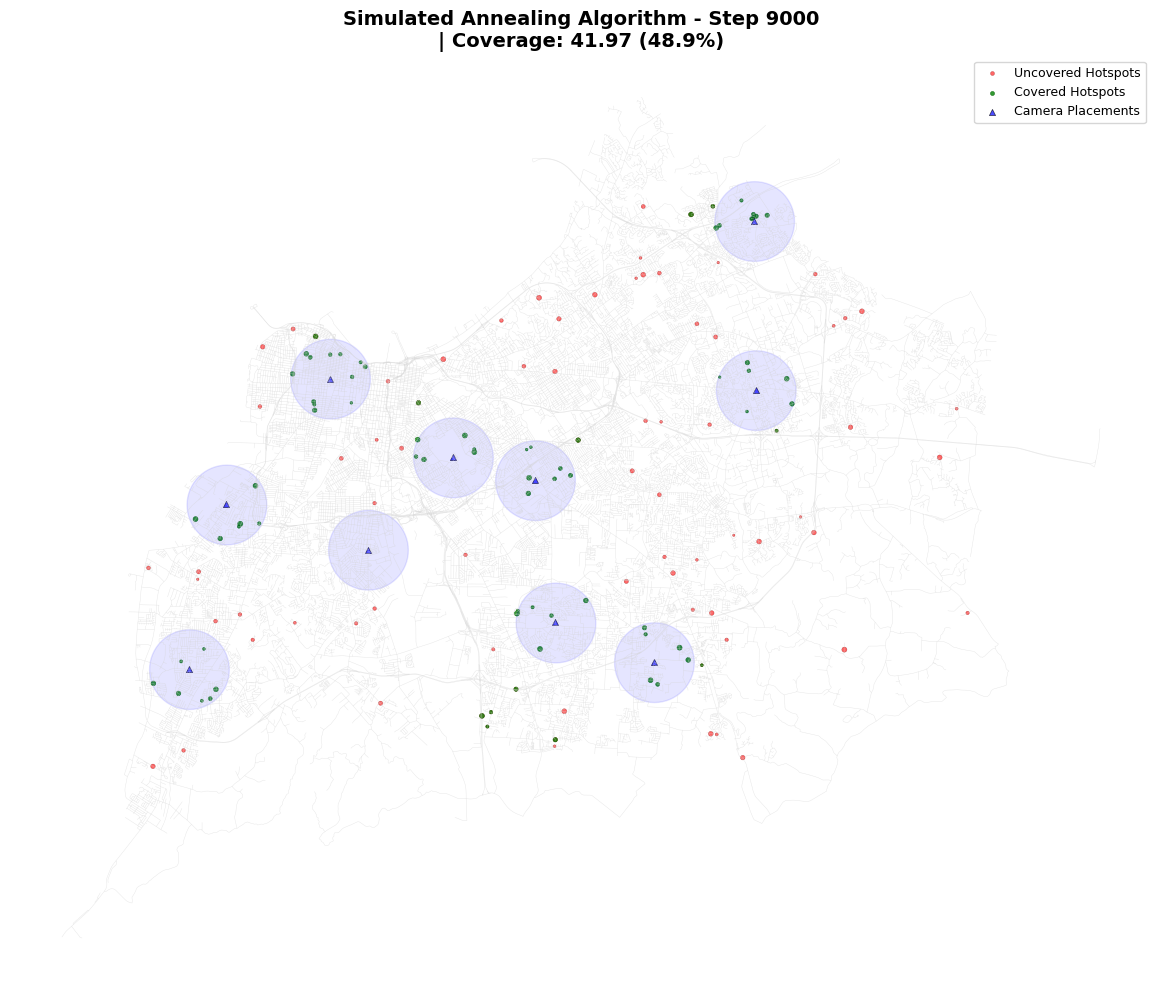

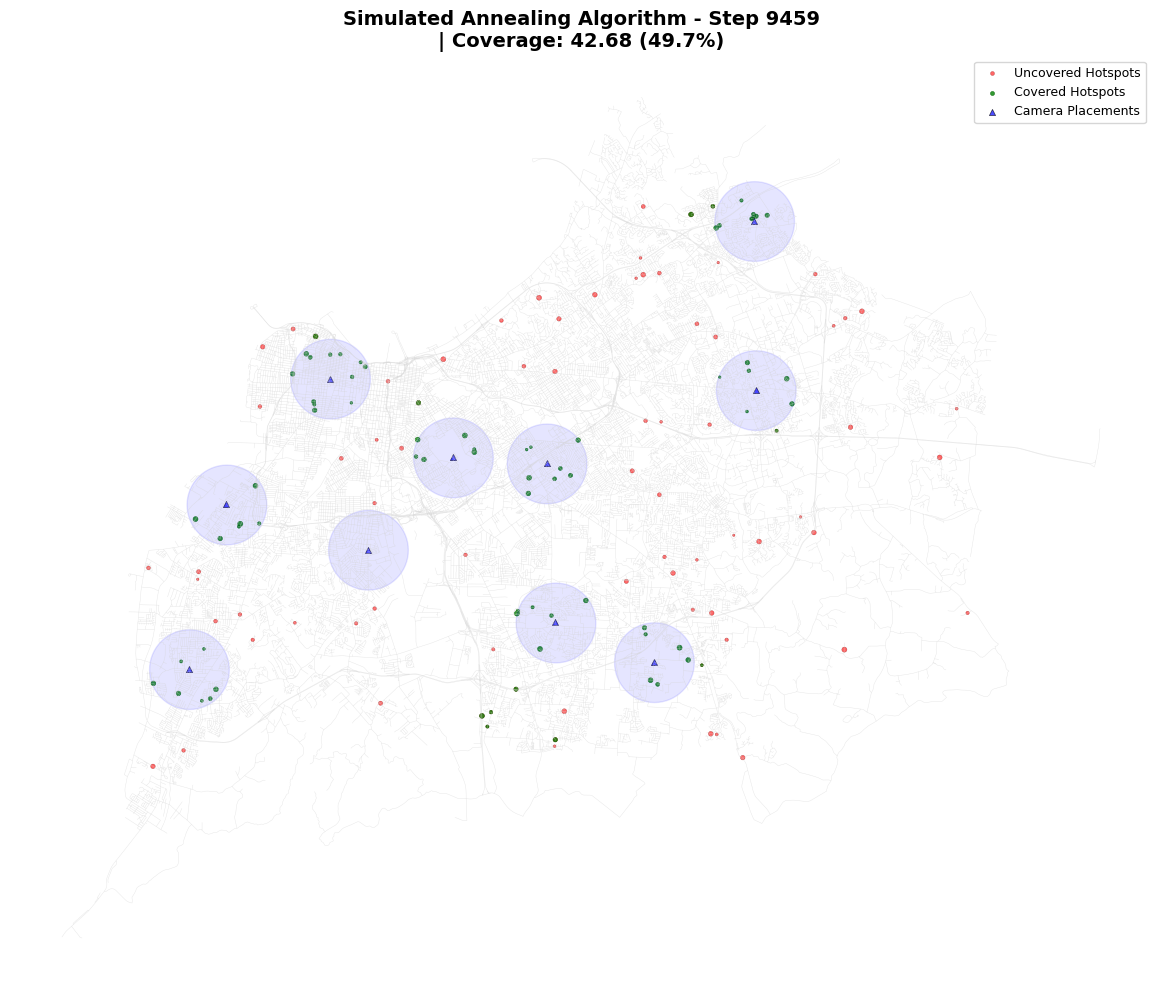

Plot coverage over time
Saved: annealing_coverage_progression.png


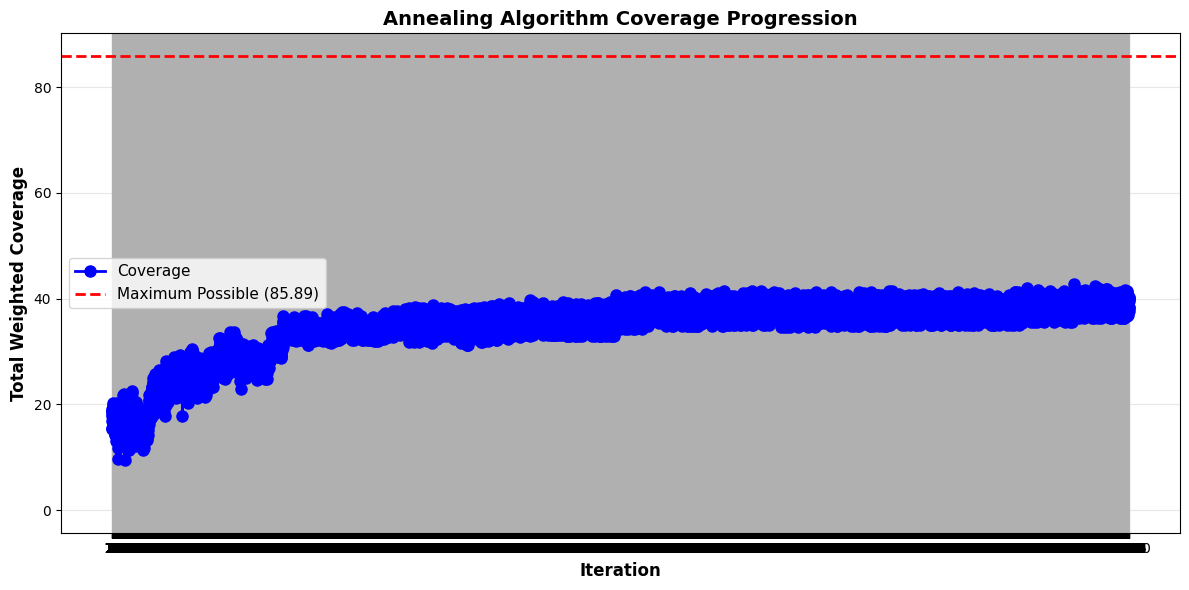

In [23]:
if should_graph:
    print("Generating Graphs")
    graph_count = 7

    i = 0
    step_size = int(len(saved_bests) / (graph_count - 2))
    finished = False
    step_visualizations = []
    while not finished:
        idx = i * step_size
        if idx >= len(saved_bests):
            idx = -1
            finished = True

        best_solution, k = saved_bests[idx]
        coverage = weighted_coverage(best_solution, hotspot_cache, hotspots_gdf)

        plot_simulated_annealing(
            camera_placements=best_solution,
            hotspot_cache=hotspot_cache,
            hotspots_gdf=hotspots_gdf,
            k=k,
            total_coverage=coverage,
            coverage_radius_meters=COVERAGE_RADIUS,
            step_visualizations=step_visualizations)

        i += 1


    # Plot coverage over time
    print("Plot coverage over time")
    plot_coverage_progression(coverage_history, hotspots_gdf)